# Imports

In [14]:
import numpy as np
import os, glob, json
from typing import Tuple, Iterable
from multiprocessing import Pool, Process
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import random
from sklearn.manifold import TSNE
import tensorflow as tf


In [15]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

# Datenimport

In [16]:
def getJsonFileNamesInFolder(path2jsonFiles: str) -> Iterable[str]:
    res = glob.glob(path2jsonFiles)
    return res

In [17]:
a = getJsonFileNamesInFolder("../data/traintest/*.json")
a[1]

'../data/traintest/1662041197516_to_1662466208815_shape_40000_4_sampleRate_4000_durationInSeconds_10.json'

In [18]:
def parseJsonFile(filename: str) -> dict:
    # start_t = time.perf_counter()
    file = open(filename)
    content = json.load(file)
    file.close()
    # end_t = time.perf_counter()
    return content

In [19]:
def parseJsonFiles(filenames: Iterable[str], processes = None, chunksize=None) -> dict:
    start_t = time.perf_counter()
    parsedJsonFiles: dict = dict()

    results = []

    # with Pool() as pool:
    #     results = pool.map(parseJsonFile, filenames)
    
    for filename in filenames:
        temp = parseJsonFile(filename)
        
        results.append(temp)

        # for filename, content, duration in results:
        #     print(f"{filename} completed in {duration:.2f}s")
    end_t = time.perf_counter()
    total_duration = end_t - start_t
    print(f"etl took {total_duration:.2f}s total")
    return results

In [20]:
a = np.ones((5, 3))

In [21]:
a

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [22]:
a[:,0] = [2,2,2,2,2]

In [23]:
a

array([[2., 1., 1.],
       [2., 1., 1.],
       [2., 1., 1.],
       [2., 1., 1.],
       [2., 1., 1.]])

In [24]:
def createXandY(path2jsonFiles: str) -> Tuple[np.ndarray, np.ndarray]:
    # (filename, dict)
    jsonFilePaths : str = getJsonFileNamesInFolder(path2jsonFiles)
    parsedFilesList = parseJsonFiles(jsonFilePaths)
    
    numberOfFiles = int(len(parsedFilesList))

    

    print(type(parsedFilesList[0]))
    
    
    
    sampleRate = int(parsedFilesList[0]["sampleRate"])
    durationInSeconds = int(parsedFilesList[0]["durationInSeconds"])
    datapointsPerChannel = sampleRate*durationInSeconds
    numberOfChannels = 3

    X = np.empty((numberOfFiles,datapointsPerChannel, numberOfChannels)) # (numberOfFiles, sampleRate*durationInSeconds, numberOfChannels)
    y = np.empty((numberOfFiles,1),dtype=object) #(numberOfFiles, 1)

    for idx, parsedFile in enumerate(parsedFilesList):
        
        X_temp = np.empty((datapointsPerChannel, numberOfChannels))
        
        X_temp[:,0] = parsedFile["x"]
        X_temp[:,1] = parsedFile["y"]
        X_temp[:,2] = parsedFile["z"]

        X[idx] = X_temp

        y[idx] = parsedFile["label"]




    return X,y 


In [25]:
X, y = createXandY("../data/traintest/*.json")

etl took 44.08s total
<class 'dict'>


In [26]:
X_evaluation, y_evaluation = createXandY("../data/evaluation/*.json")

etl took 9.15s total
<class 'dict'>


In [27]:
print(X.shape, y.shape)

(1987, 40000, 3) (1987, 1)


In [28]:
X[0].shape

(40000, 3)

In [29]:
def getIndicesOfFirstOccurranceOfLabel(searchlabel:str, y):
    labels = np.unique(y)
    if searchlabel not in labels:
        raise Exception("invalid label", "available labels: ", labels)
    indices = []
    for idx, label in enumerate(y):
        if label[0] == searchlabel:
            indices.append(idx)
    return indices

## Erste Visualisierung jeder Klasse

In [30]:
def plotRandomDatapointsOfLabel(searchLabel, X, y, type="line", axis=["z"]):
    plt.rcParams["figure.figsize"] = (20, 3)
    #searchLabel = "Gehen"
    
    indices = getIndicesOfFirstOccurranceOfLabel(searchLabel,y)
    randomIndex = random.randint(0, len(indices)-1)
    #randomIndex = indices[3]
    print(y[indices[randomIndex]], "Anzahl Aufnahmen: ", len(indices))
    if type=="line":
        plt.plot(X[indices[randomIndex]][:,2])
        plt.ylabel("Beschleunigung in g")
        plt.xlabel("Anzahl der Datenpunkte")
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [31]:
def plotRandomDatapointsOfEachLabel(X, y, type="line", axis=["z"]):
    labels = np.unique(y)
    for label in labels:
        plotRandomDatapointsOfLabel(label, X, y, type)

['Gehen'] Anzahl Aufnahmen:  235


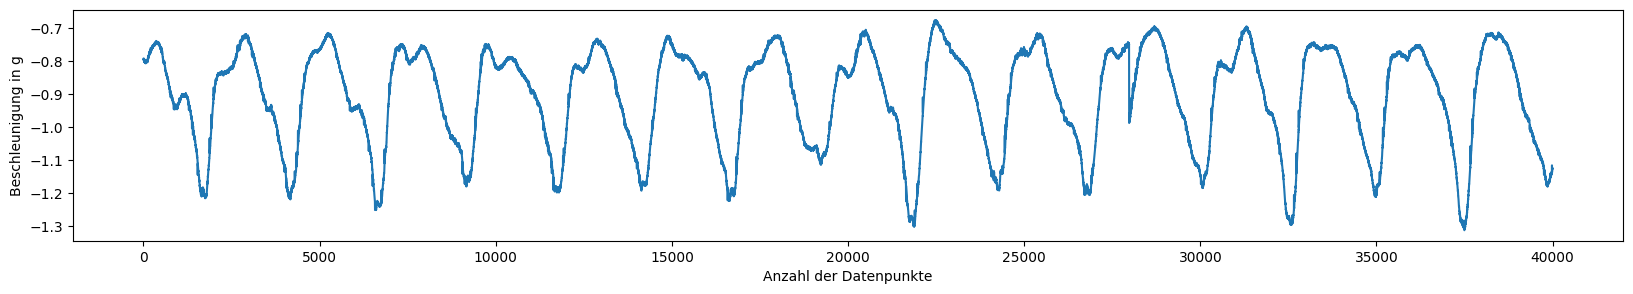

In [32]:
plotRandomDatapointsOfLabel("Gehen", X, y)


['GLT_Rollwagen'] Anzahl Aufnahmen:  241


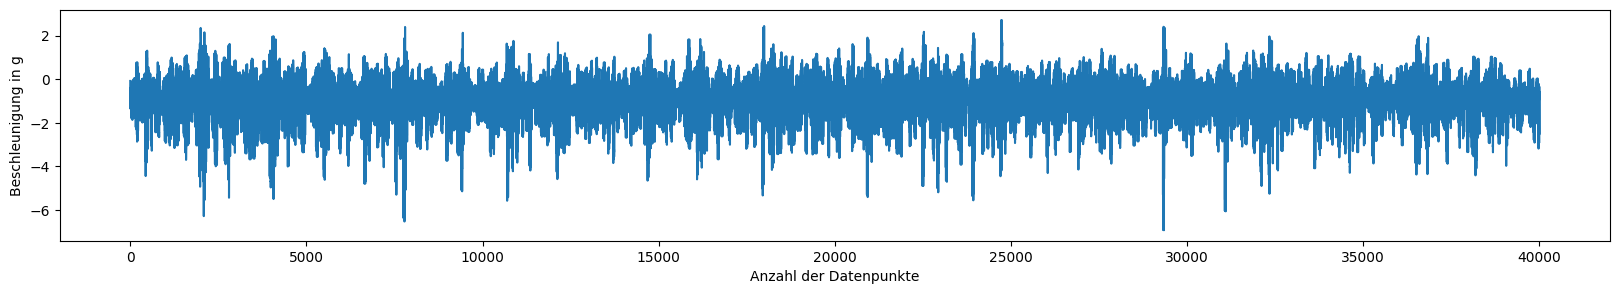

['Gehen'] Anzahl Aufnahmen:  235


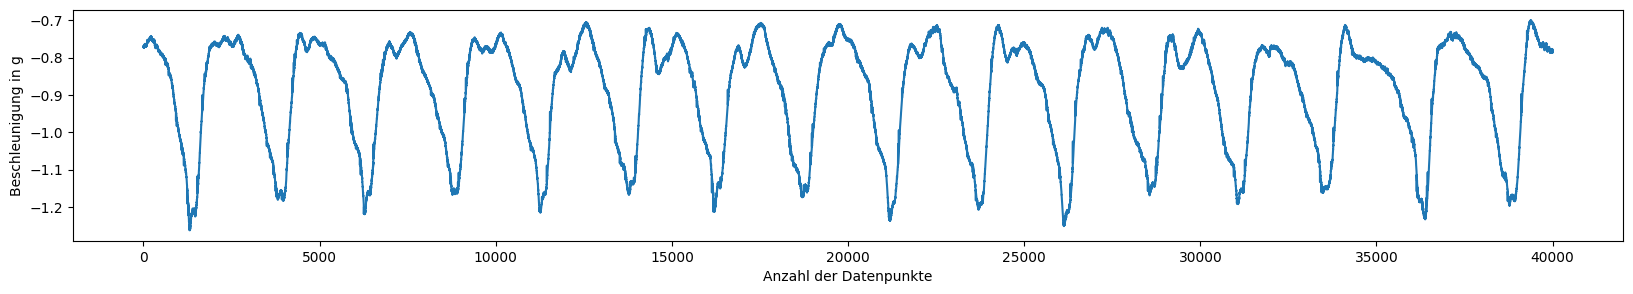

['HebenSenken'] Anzahl Aufnahmen:  130


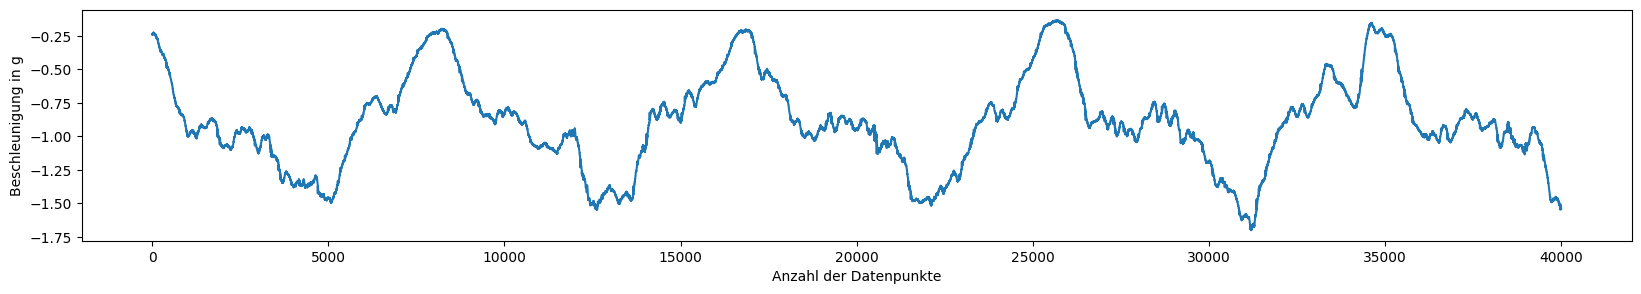

['Hubwagen'] Anzahl Aufnahmen:  257


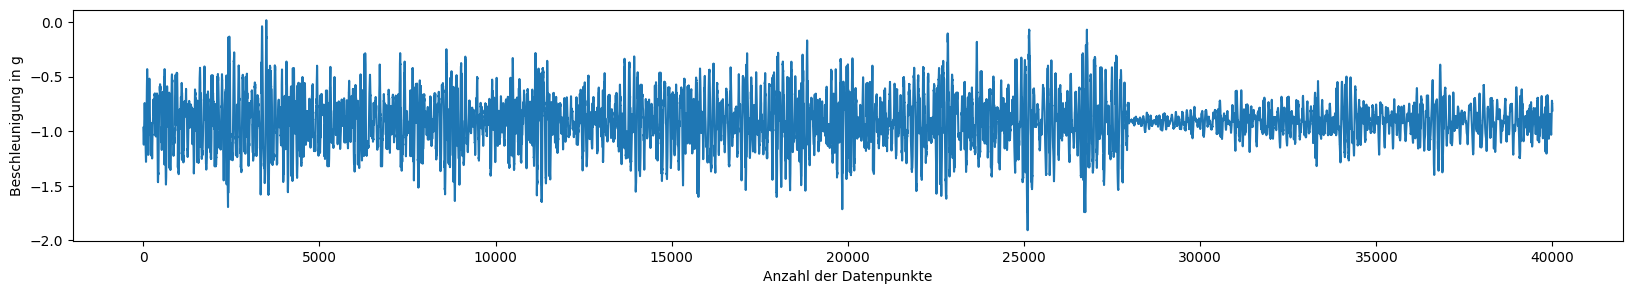

['Kiste liegt'] Anzahl Aufnahmen:  191


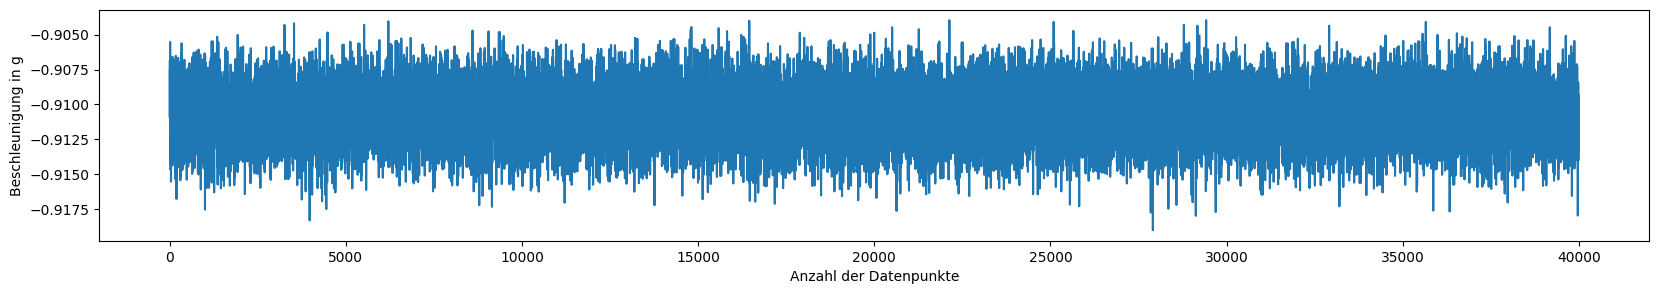

['Rollenbahn'] Anzahl Aufnahmen:  226


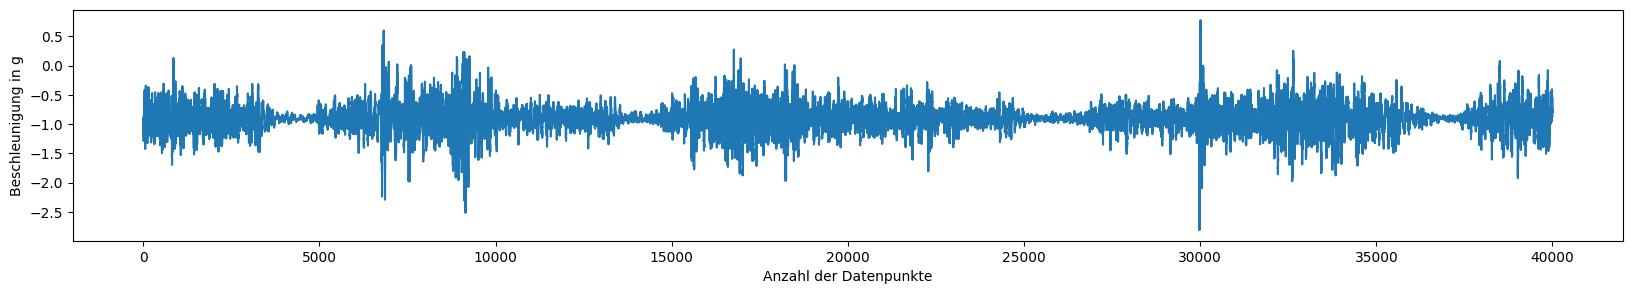

['Rolltisch'] Anzahl Aufnahmen:  218


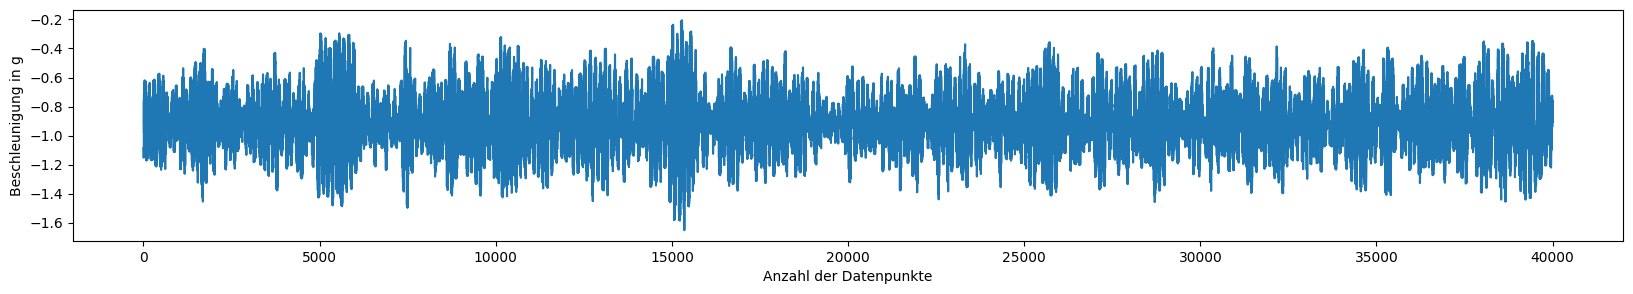

['Sackkarre'] Anzahl Aufnahmen:  248


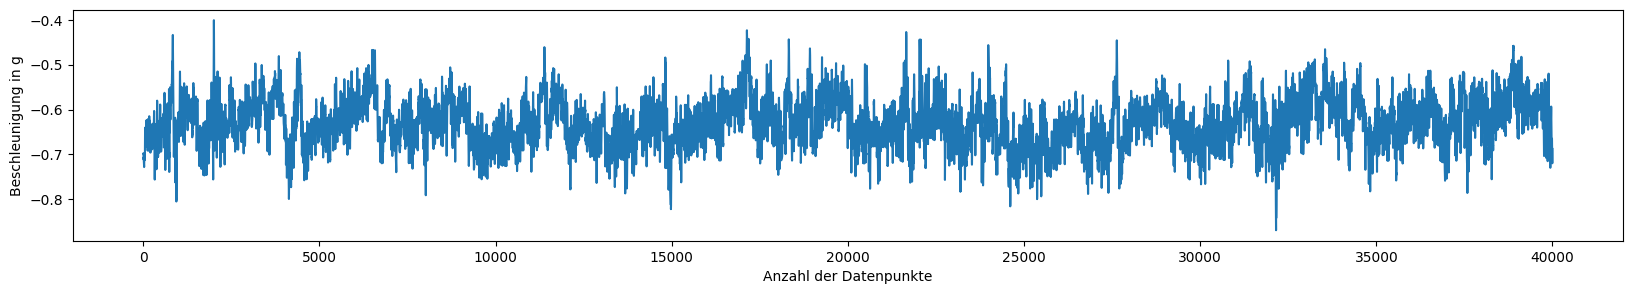

['vert. drehen'] Anzahl Aufnahmen:  241


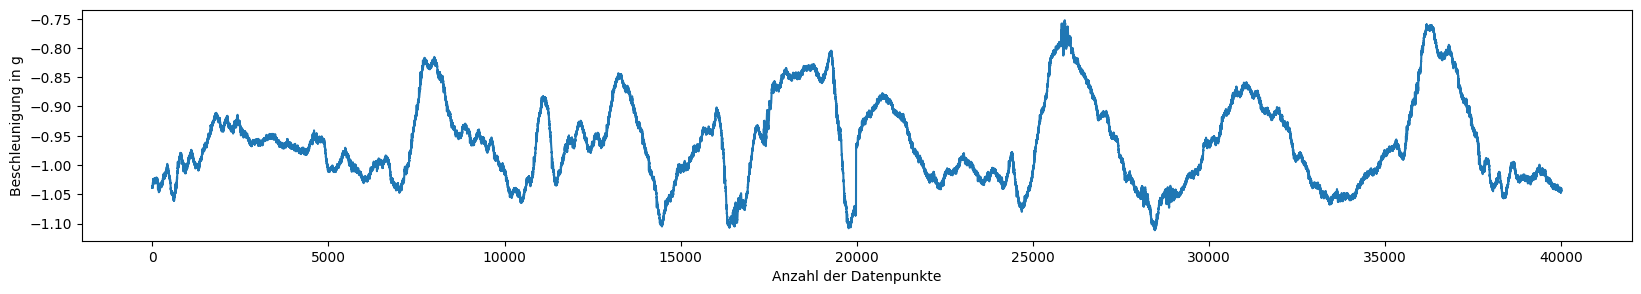

In [33]:
plotRandomDatapointsOfEachLabel(X, y,type="line")

['GLT_Rollwagen'] Anzahl Aufnahmen:  45


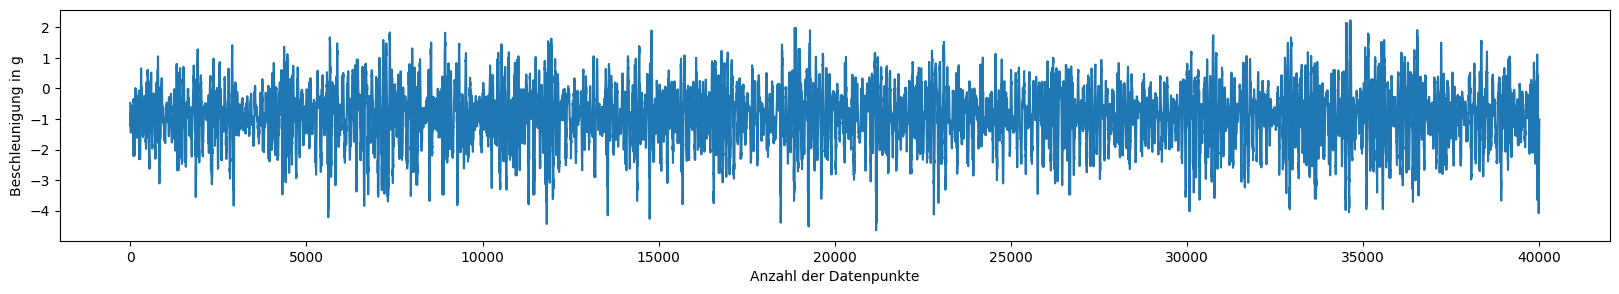

['Gehen'] Anzahl Aufnahmen:  45


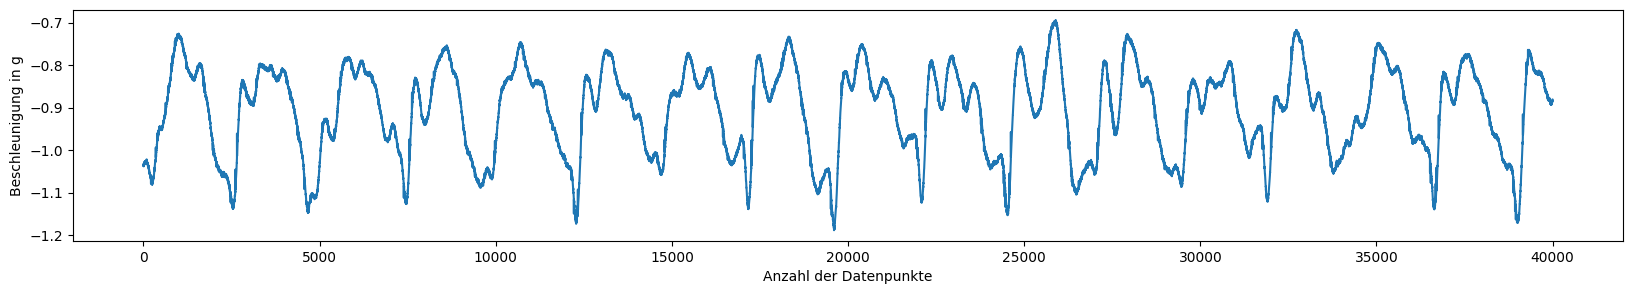

['HebenSenken'] Anzahl Aufnahmen:  45


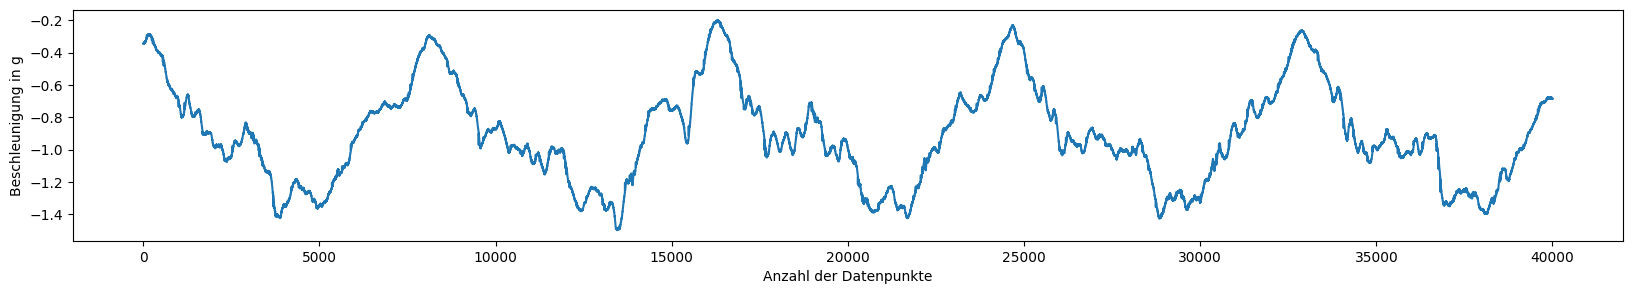

['Hubwagen'] Anzahl Aufnahmen:  45


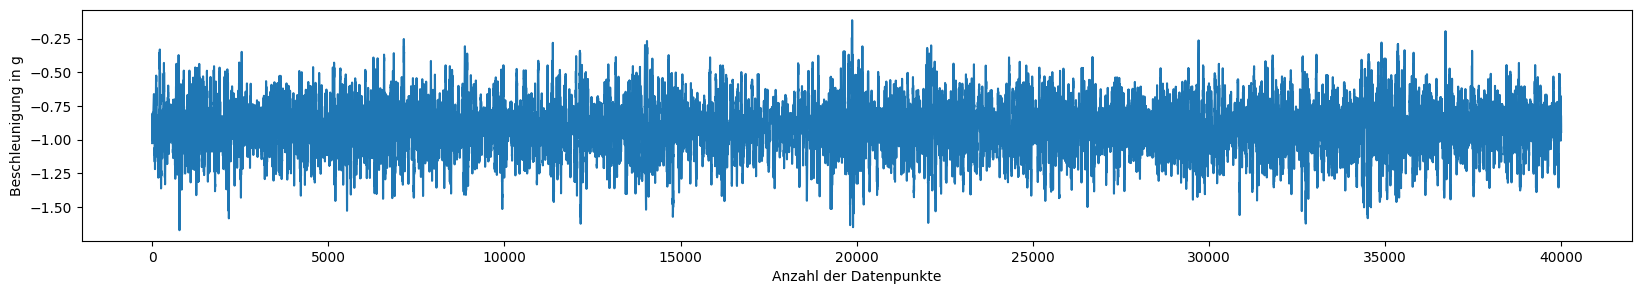

['Kiste liegt'] Anzahl Aufnahmen:  45


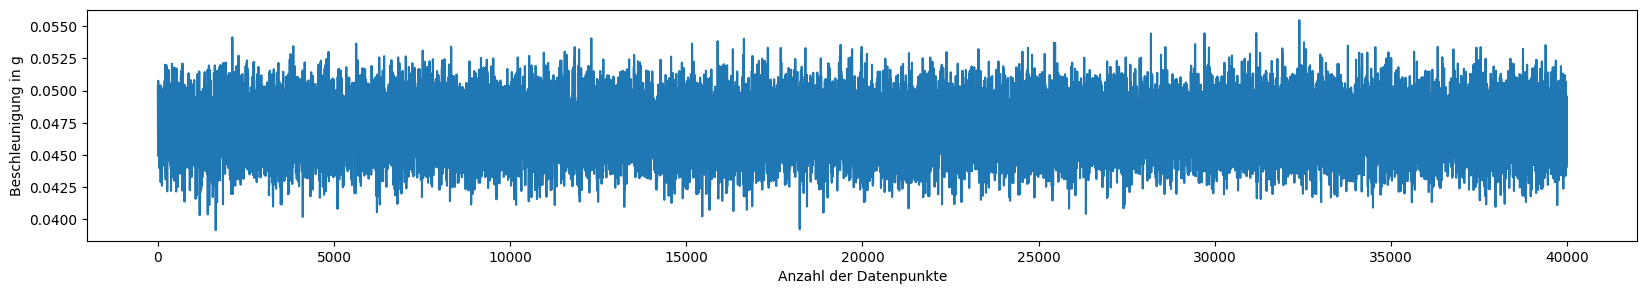

['Rollenbahn'] Anzahl Aufnahmen:  45


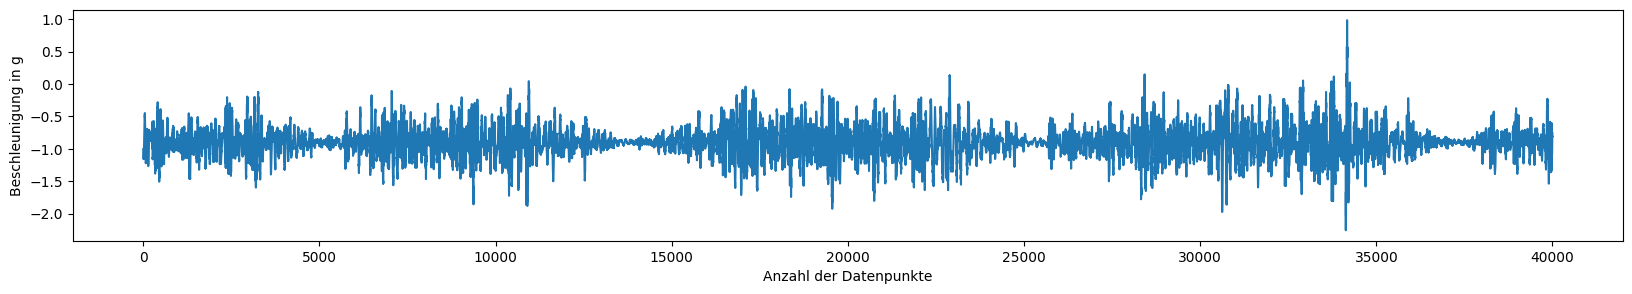

['Rolltisch'] Anzahl Aufnahmen:  45


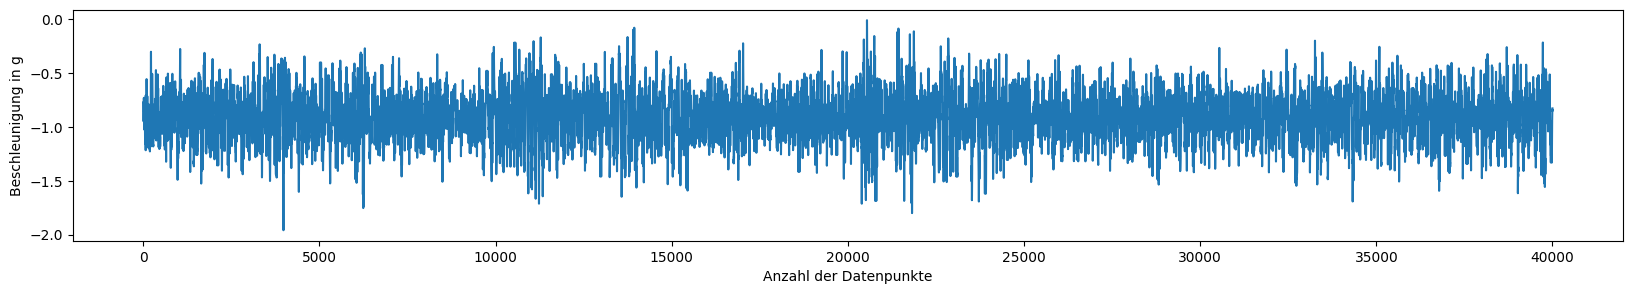

['Sackkarre'] Anzahl Aufnahmen:  45


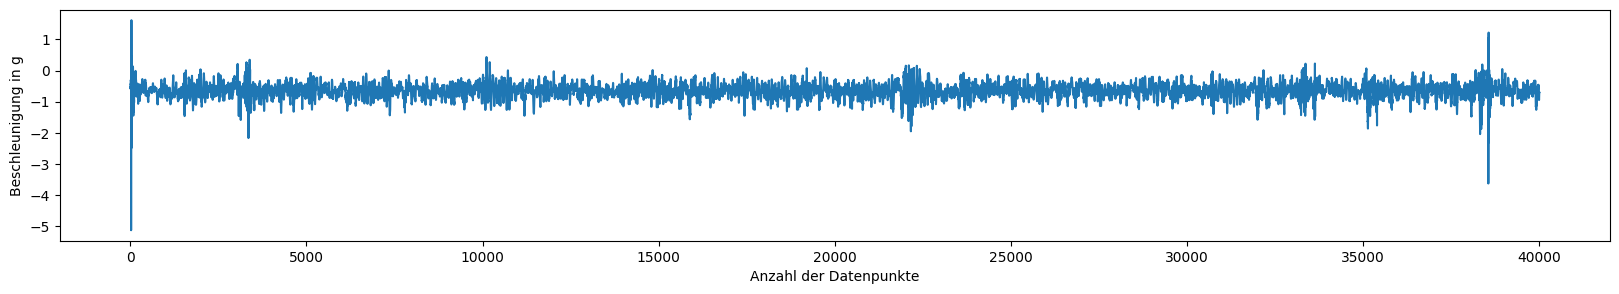

['vert. drehen'] Anzahl Aufnahmen:  45


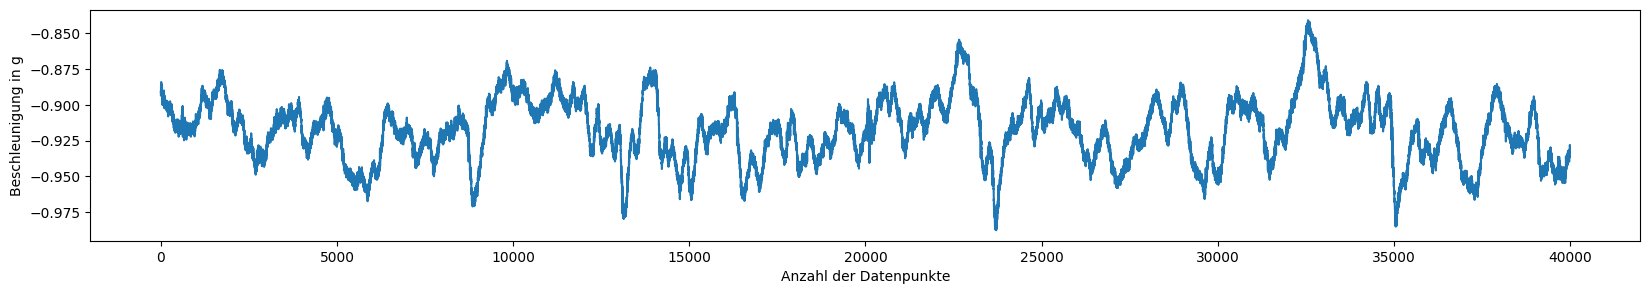

In [34]:
plotRandomDatapointsOfEachLabel(X_evaluation, y_evaluation,type="line")

## Fehlerhafte Daten finden und aussortieren

Wie können fehlerhafte Daten gefunden werden [per Boxplots]  und Aufnahmen markieren welche außerhalb der Grenzen liege:
1. per Boxplots
2. Null-Werte finden
3. Aufnahmen mit übernatürlich hohen Werten z.B über 1000 g finden => sichere Ausreißer
2. per Verteilung => welche Aufnahmen weichen vom Charakter von den anderen Aufnahmen der gleichen Klasse ab
1. Durchschnittswert der g-Werte berechnen 

In [35]:
np.NAN!=np.NAN

True

In [36]:
def nullCheck(arr):
    contain = False

    if np.isnan(X).any():
        contain = True

    for i in arr:
        if(i is np.NAN or i is None or i is np.NaN):
            contain = True
            break

    if(contain):
        print("The Array contains NaN values")
    else:
        print("The Array does not contain NaN values")

In [37]:
nullCheck(X)

The Array does not contain NaN values


In [38]:
nullCheck(X_evaluation)

The Array does not contain NaN values


In [39]:
X.shape

(1987, 40000, 3)

In [40]:
def findIllogicalValues(arr,threshold):    
    indices = []
    
    for idx, recording in enumerate(arr):
        flag = False
        for datapoint in recording: 
            for i, channel in enumerate(datapoint):                
                temp = channel
                if (abs(temp) > threshold):                    
                    flag = True
        if(flag):
            indices.append(idx)
    return indices

In [41]:
badIndices = findIllogicalValues(X, threshold=100)

In [42]:
badIndices_evaluation = findIllogicalValues(X_evaluation, threshold=100)

In [43]:
badIndices_evaluation

[]

In [44]:
badIndices

[569, 1205, 1866, 1926]

['HebenSenken']


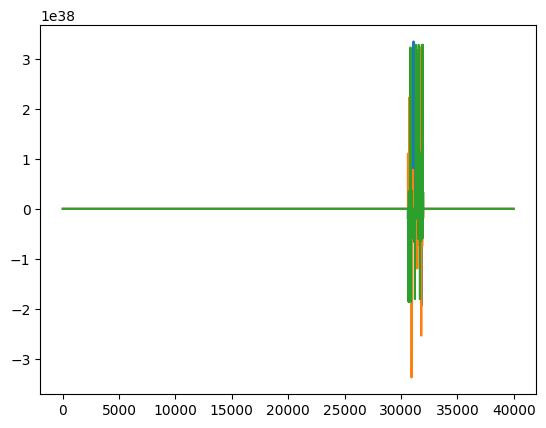

In [45]:
print(y[569])
plt.plot(X[569])
plt.show()

In [46]:
X.shape
X1 = np.delete(X, badIndices, axis=0)
y1 = np.delete(y, badIndices, axis=0)

In [47]:
print(X1.shape, y1.shape)


(1983, 40000, 3) (1983, 1)


['GLT_Rollwagen'] Anzahl Aufnahmen:  241


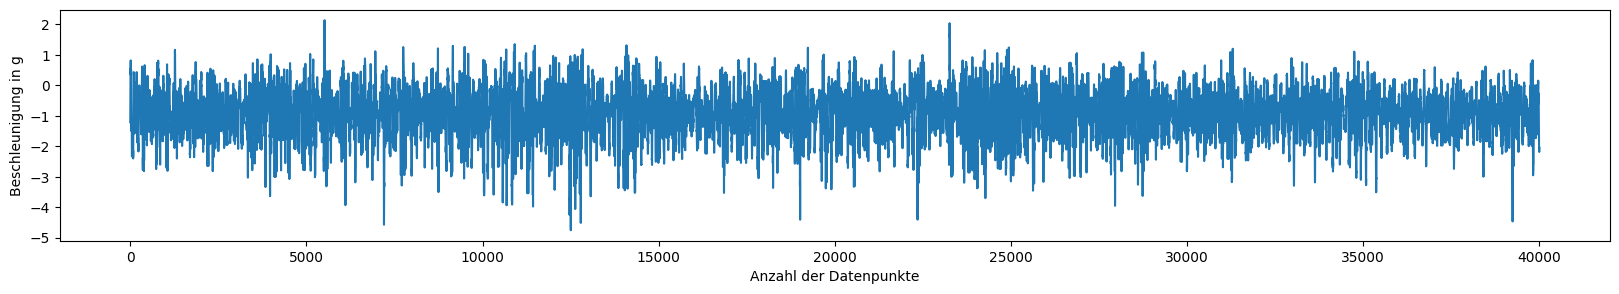

['Gehen'] Anzahl Aufnahmen:  235


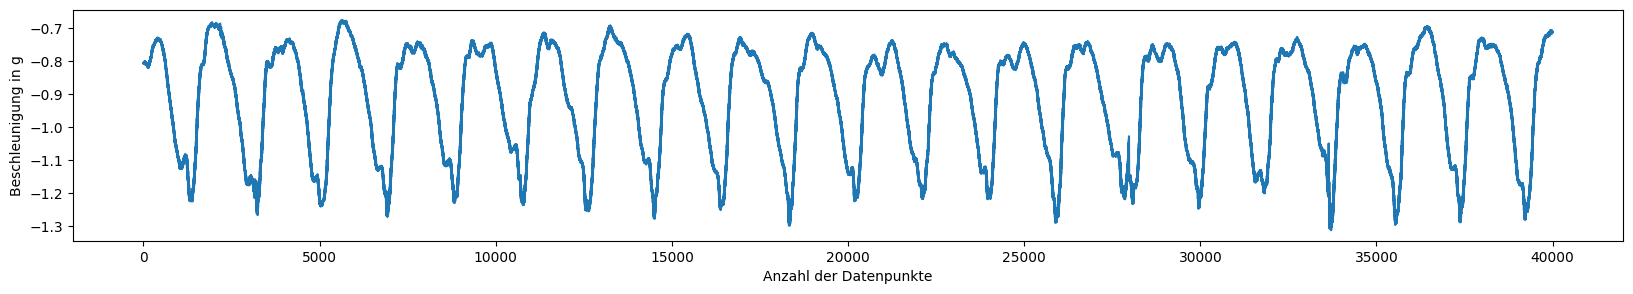

['HebenSenken'] Anzahl Aufnahmen:  128


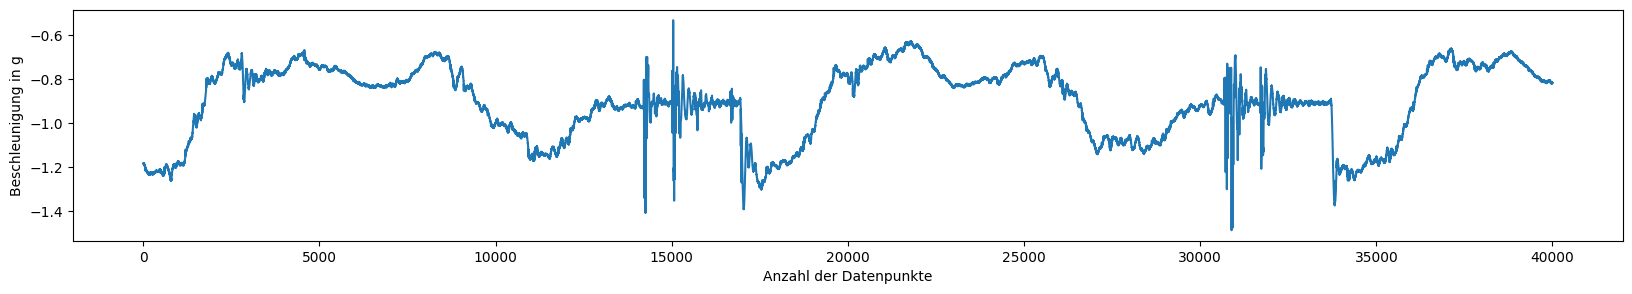

['Hubwagen'] Anzahl Aufnahmen:  257


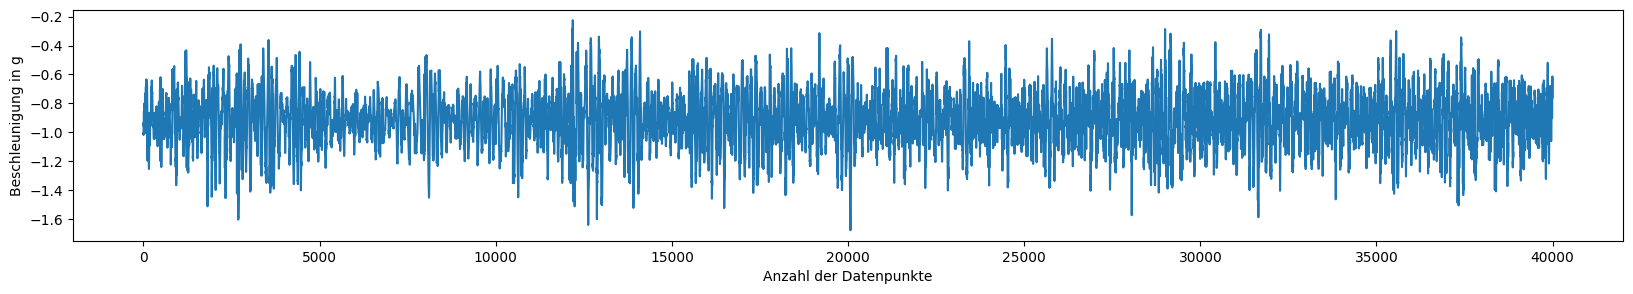

['Kiste liegt'] Anzahl Aufnahmen:  189


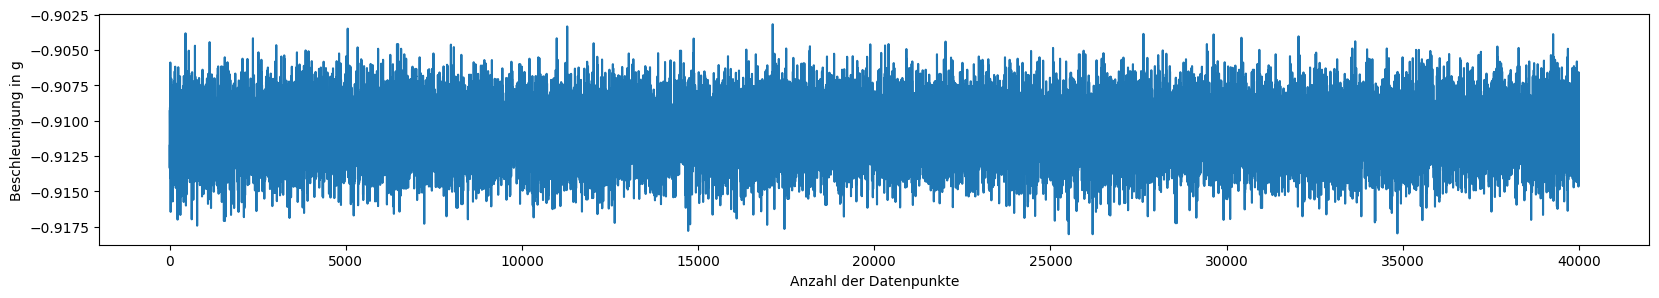

['Rollenbahn'] Anzahl Aufnahmen:  226


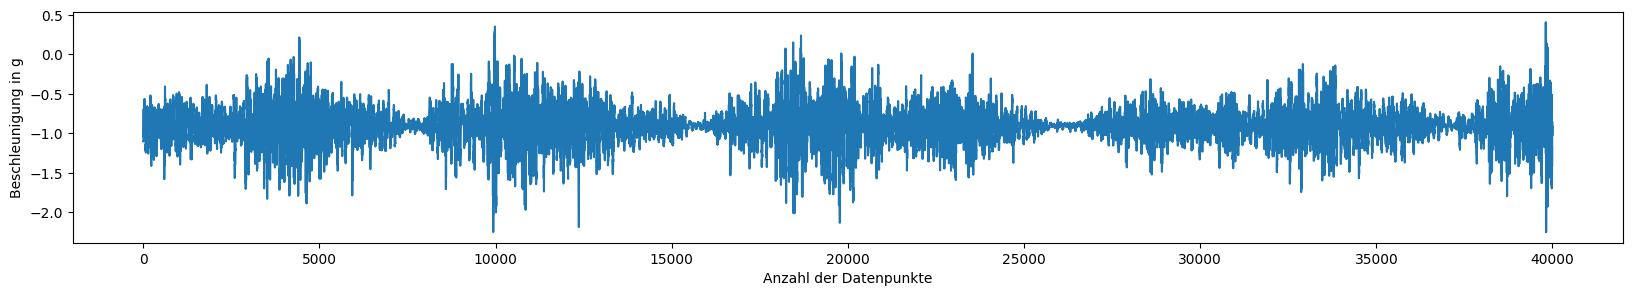

['Rolltisch'] Anzahl Aufnahmen:  218


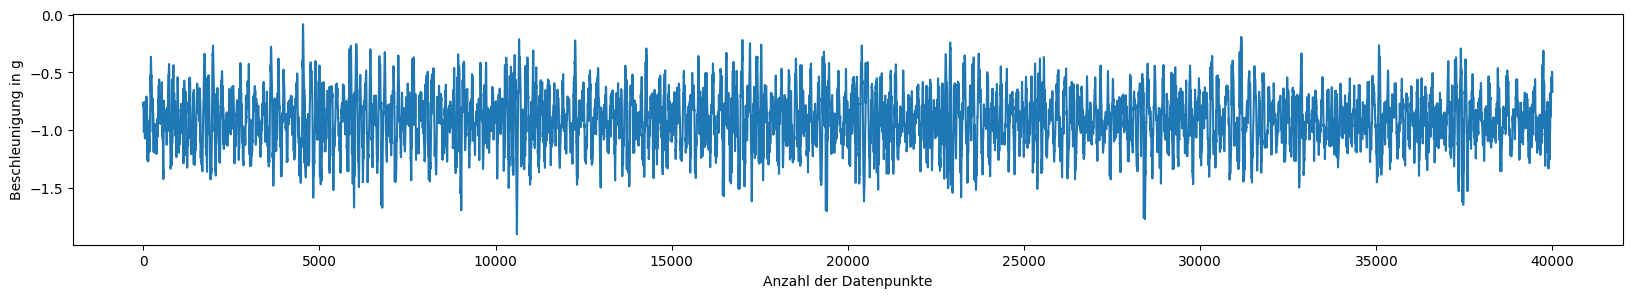

['Sackkarre'] Anzahl Aufnahmen:  248


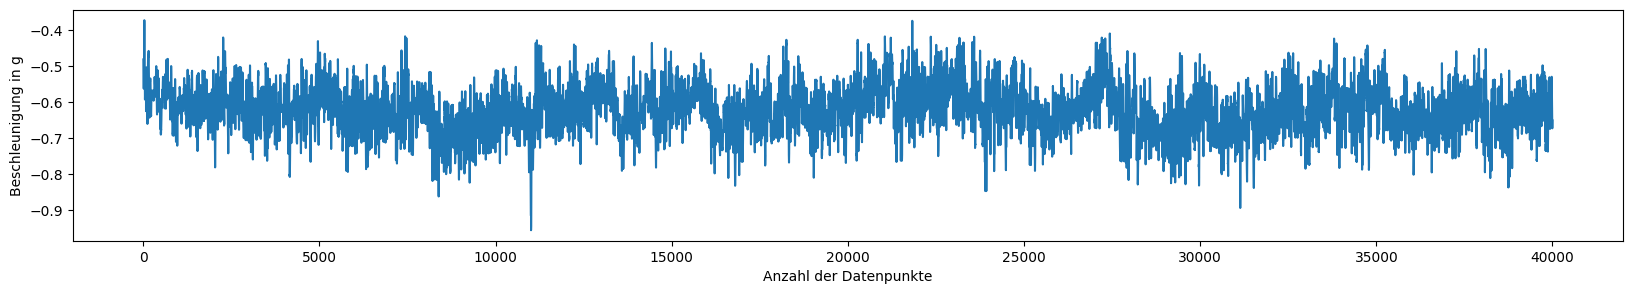

['vert. drehen'] Anzahl Aufnahmen:  241


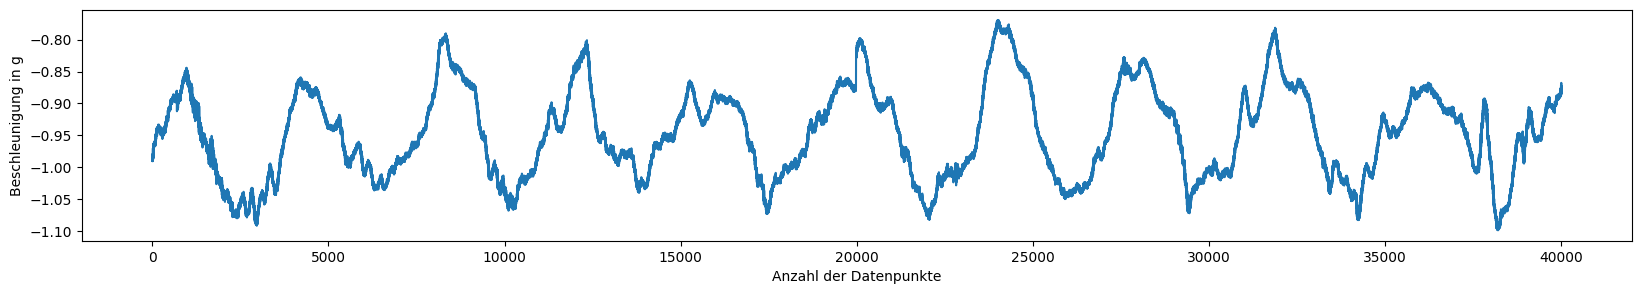

In [48]:
plotRandomDatapointsOfEachLabel(X1, y1)

In [49]:
np.max(X1)

10.223596572875977

## T-SNE

In [50]:
X1[:,:,2].shape

(1983, 40000)

In [51]:
X1 = X1.astype(float)
X1_embedded = TSNE(n_components=2, init='random', n_jobs=-1, perplexity=5).fit_transform(X1[:,:,2])

In [52]:
np.unique(y1)

array(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt',
       'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'],
      dtype=object)

In [53]:
colorLookup = dict.fromkeys(np.unique(y1))

In [54]:
for idx, key in enumerate(colorLookup):
    print(f"{idx} : {key}")
    colorLookup[key] = idx

0 : GLT_Rollwagen
1 : Gehen
2 : HebenSenken
3 : Hubwagen
4 : Kiste liegt
5 : Rollenbahn
6 : Rolltisch
7 : Sackkarre
8 : vert. drehen


In [55]:
colorLookup['Gehen']

1

In [56]:
np.unique(y1)

array(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt',
       'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'],
      dtype=object)

In [57]:
colors = np.zeros(len(X1))
for idx, label in enumerate(y1):    
    colors[idx] = colorLookup[label[0]]

In [58]:
colorLookup.keys()

dict_keys(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt', 'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'])

In [59]:
np.unique(colors)

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

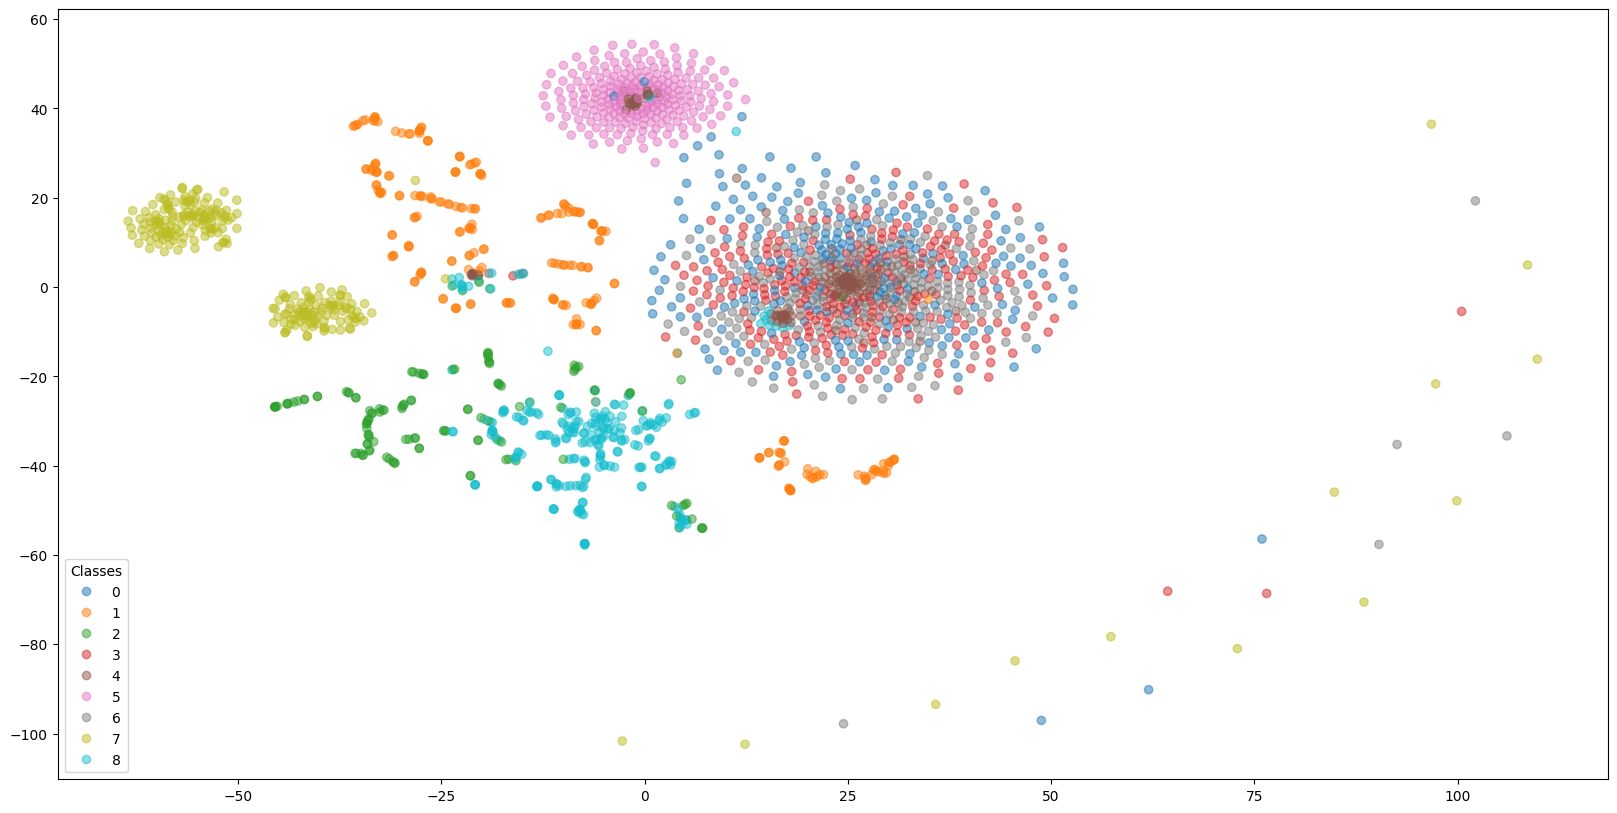

In [60]:

plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
scatter = ax.scatter(X1_embedded[:,0], X1_embedded[:,1], c=colors, alpha=0.5, cmap="tab10")
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")

# plt.legend()

plt.show()

In [61]:
for idx, key in enumerate(colorLookup):
    print(f"{idx} : {key}")
    colorLookup[key] = idx

0 : GLT_Rollwagen
1 : Gehen
2 : HebenSenken
3 : Hubwagen
4 : Kiste liegt
5 : Rollenbahn
6 : Rolltisch
7 : Sackkarre
8 : vert. drehen


In [62]:
import numpy as np
from scipy import signal
def applyLowPassFilter(raw_accel_data):
    # set the filter parameters
    fs = 4000  # sampling frequency in Hz
    fc = 1100  # cutoff frequency in Hz
    order = 4  # filter order

    # calculate the filter coefficients
    b, a = signal.butter(order, fc / (fs / 2), 'low')

    # apply the filter to each recording of acceleration data
    filtered_accel_data = np.zeros_like(raw_accel_data)

    for i in range(raw_accel_data.shape[0]):
        filtered_accel_data[i,:,:] = signal.filtfilt(b, a, raw_accel_data[i,:,:], axis=0)

    return filtered_accel_data

In [63]:
X1.shape

(1983, 40000, 3)

In [64]:
X1_filtered = applyLowPassFilter(X1)

In [65]:
X_filtered_evaluation = applyLowPassFilter(X_evaluation)

['GLT_Rollwagen'] Anzahl Aufnahmen:  45


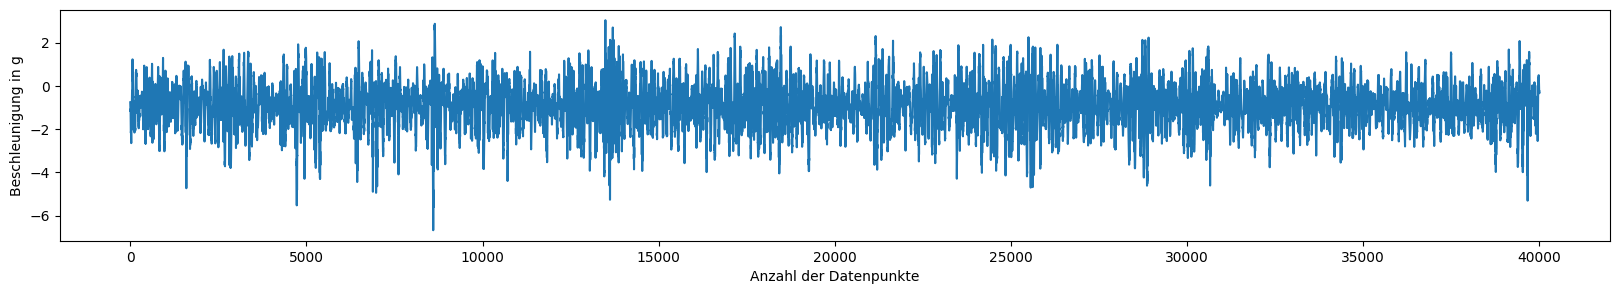

['Gehen'] Anzahl Aufnahmen:  45


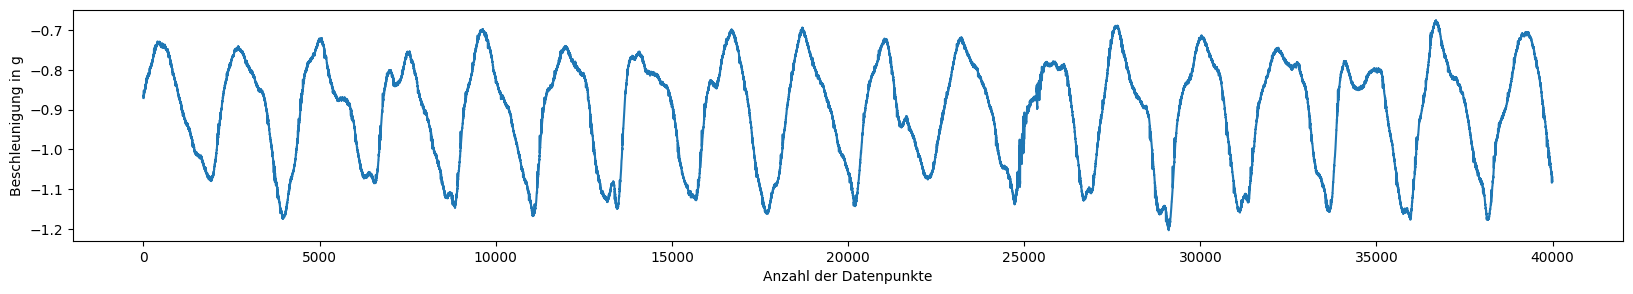

['HebenSenken'] Anzahl Aufnahmen:  45


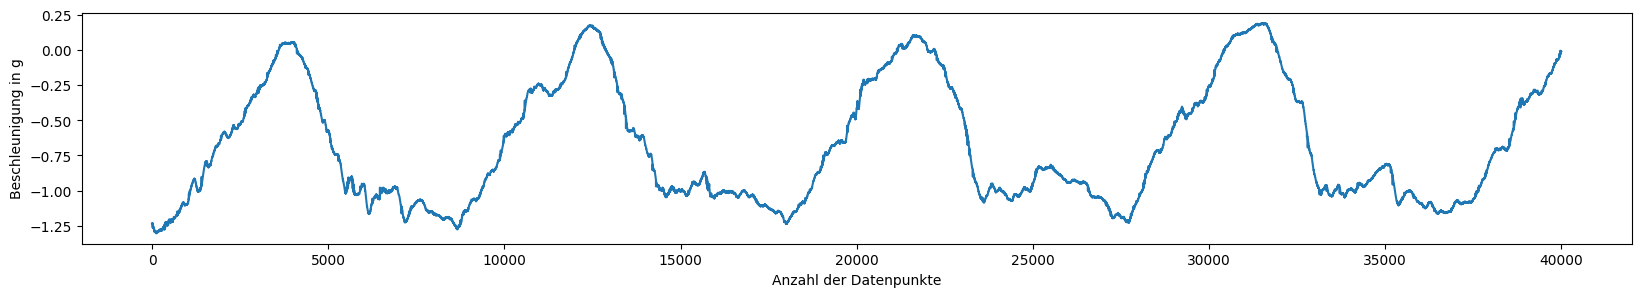

['Hubwagen'] Anzahl Aufnahmen:  45


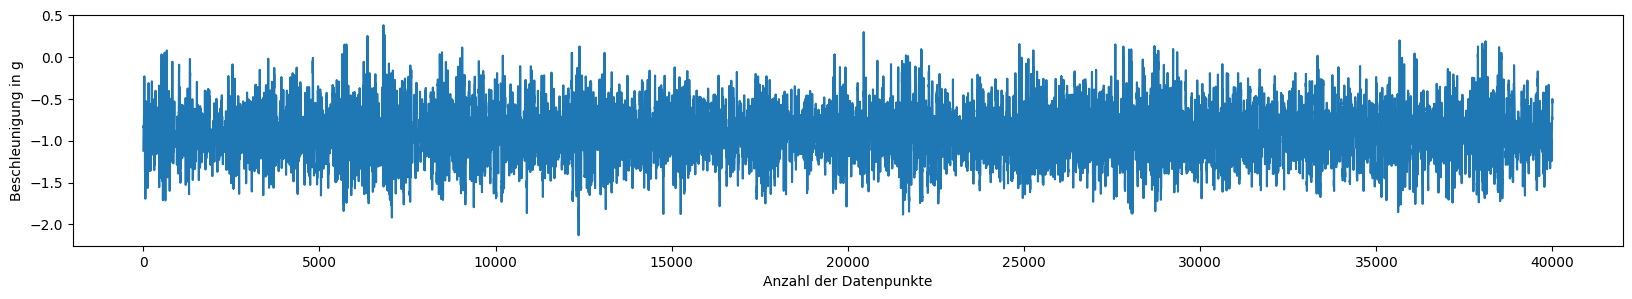

['Kiste liegt'] Anzahl Aufnahmen:  45


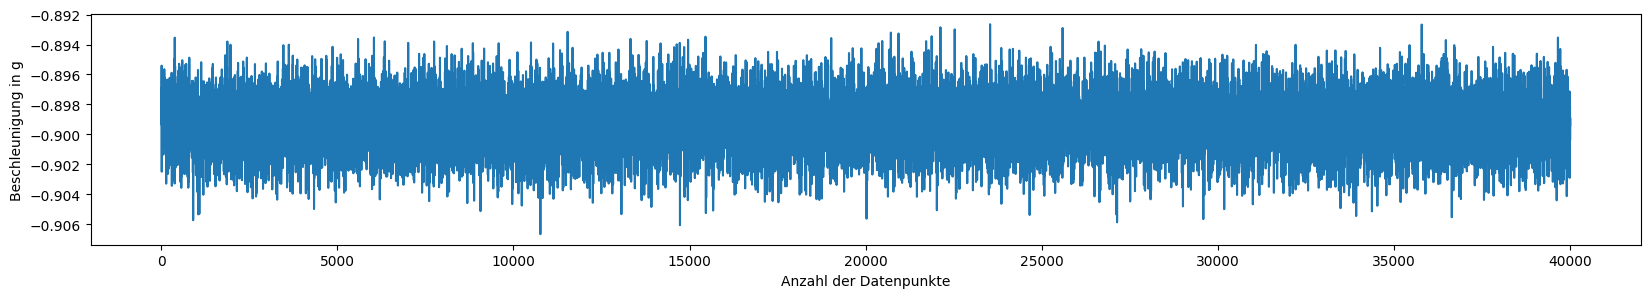

['Rollenbahn'] Anzahl Aufnahmen:  45


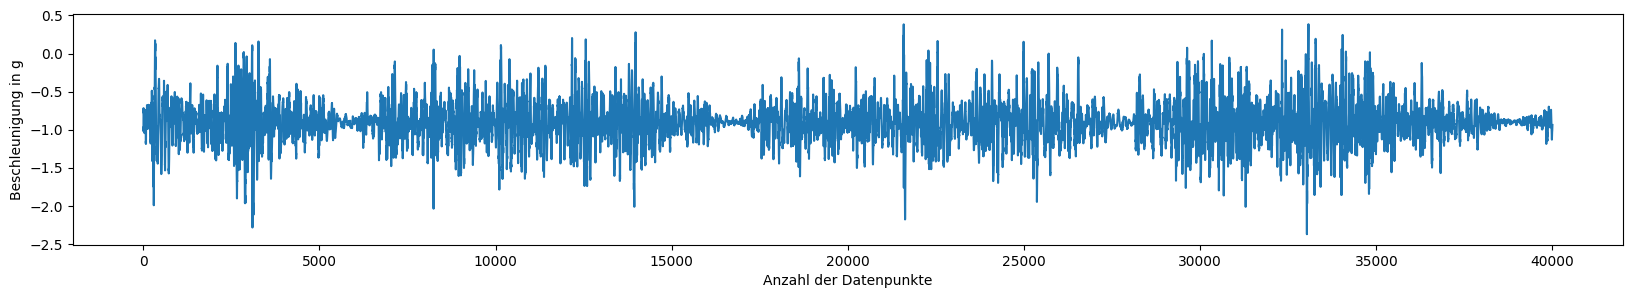

['Rolltisch'] Anzahl Aufnahmen:  45


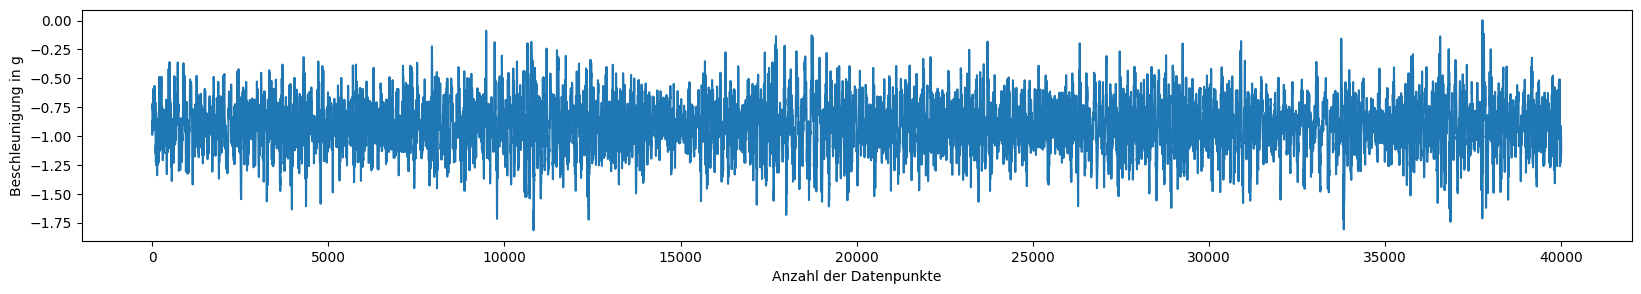

['Sackkarre'] Anzahl Aufnahmen:  45


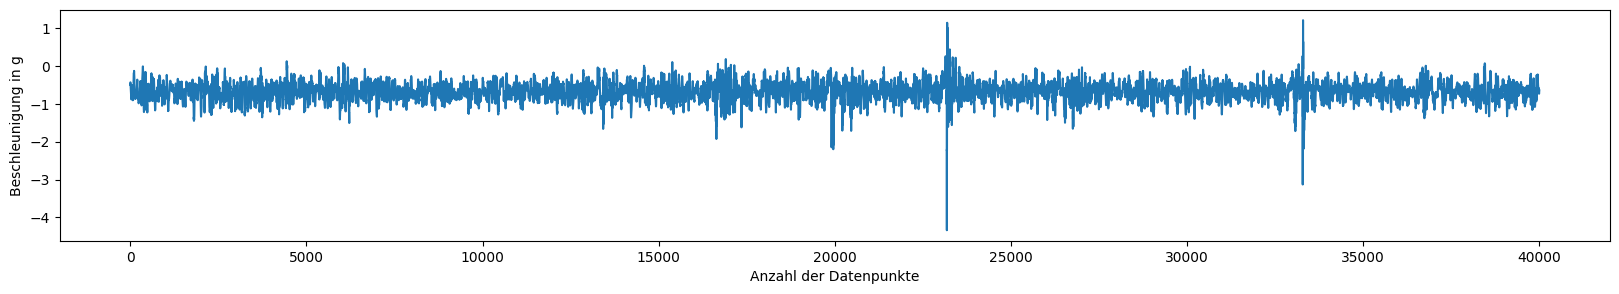

['vert. drehen'] Anzahl Aufnahmen:  45


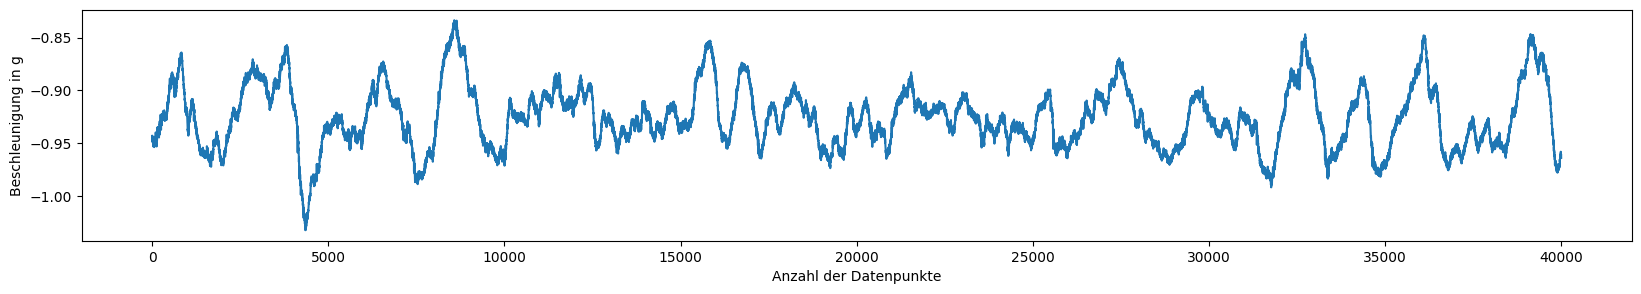

In [66]:
plotRandomDatapointsOfEachLabel(X_filtered_evaluation, y_evaluation)

['GLT_Rollwagen'] Anzahl Aufnahmen:  241


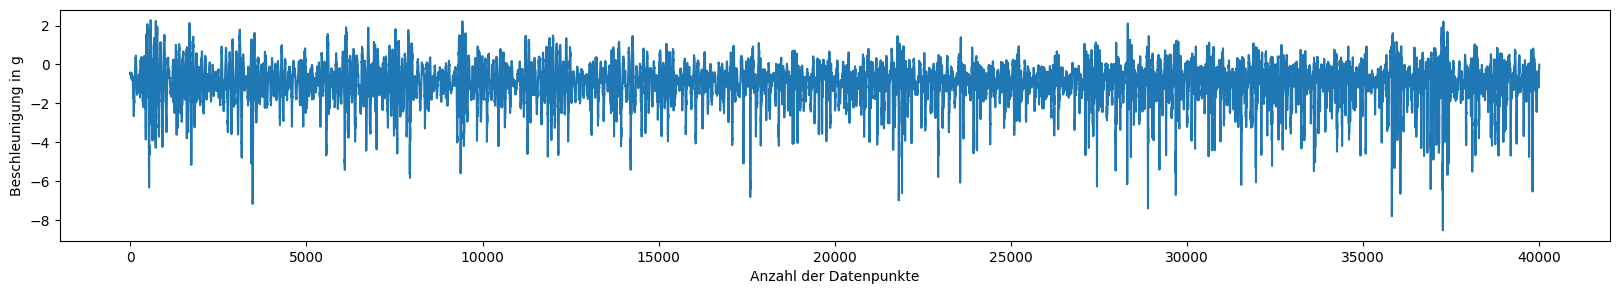

['Gehen'] Anzahl Aufnahmen:  235


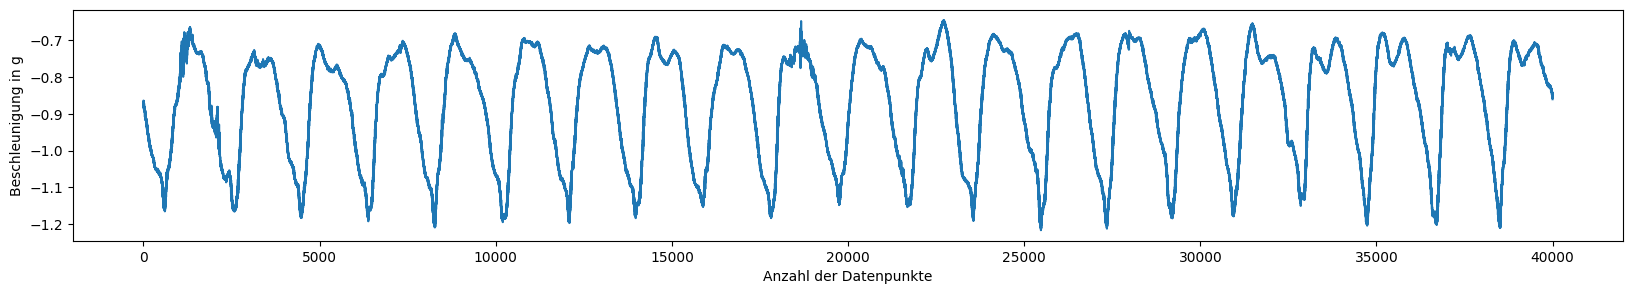

['HebenSenken'] Anzahl Aufnahmen:  128


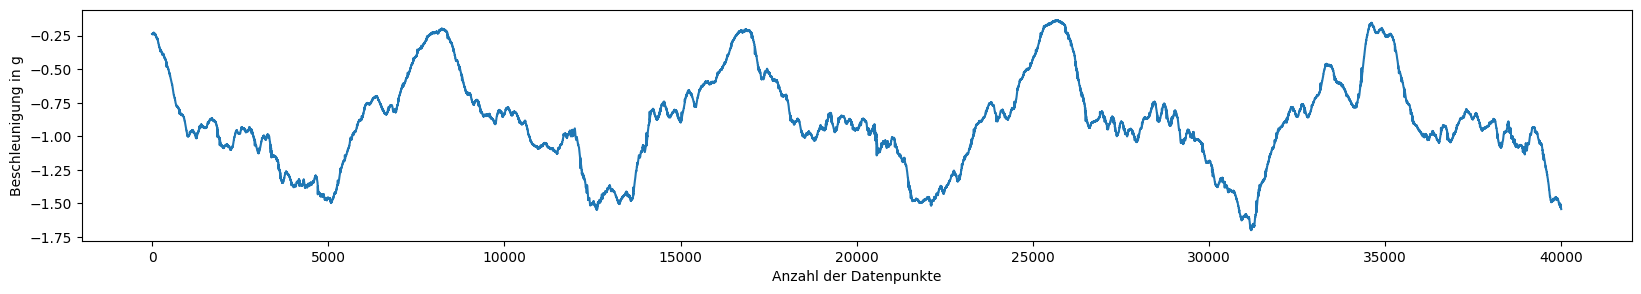

['Hubwagen'] Anzahl Aufnahmen:  257


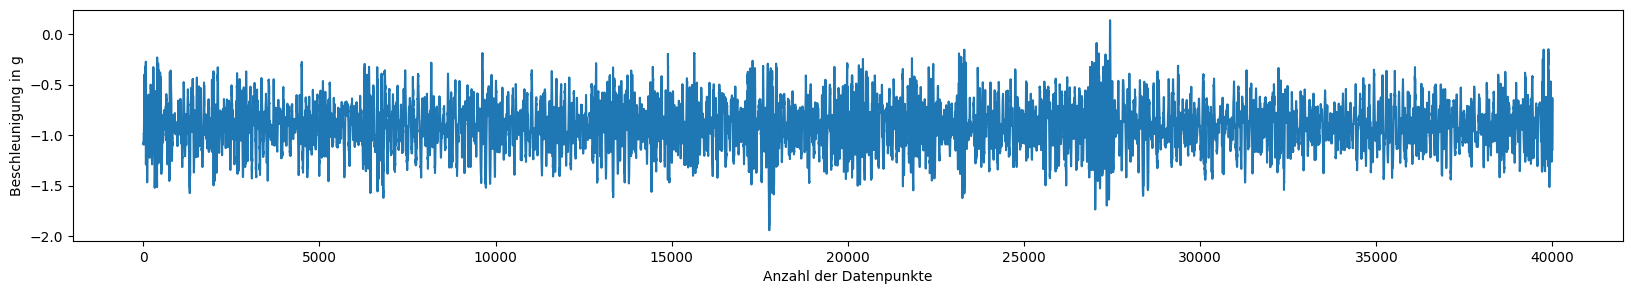

['Kiste liegt'] Anzahl Aufnahmen:  189


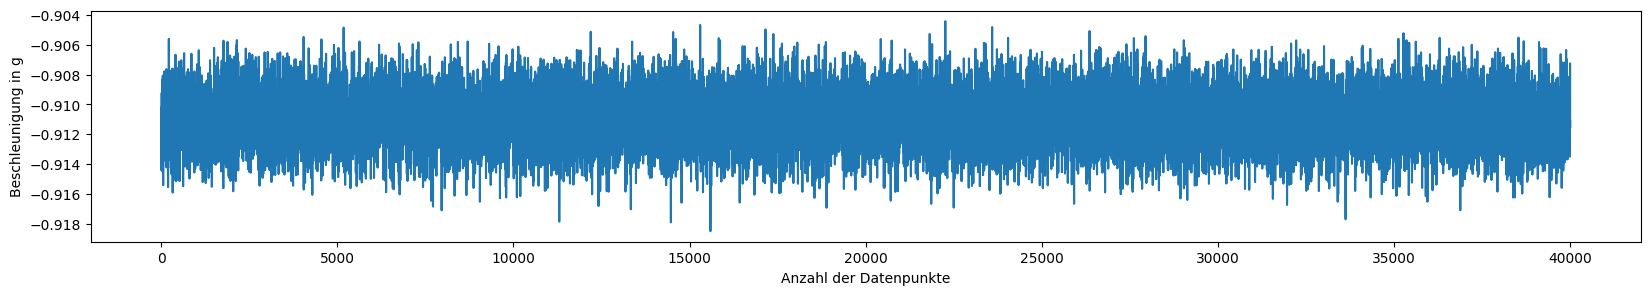

['Rollenbahn'] Anzahl Aufnahmen:  226


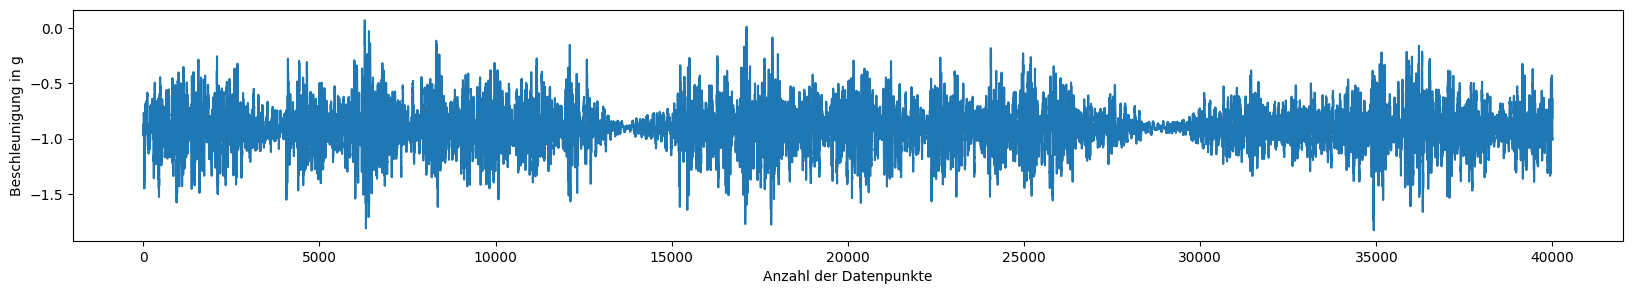

['Rolltisch'] Anzahl Aufnahmen:  218


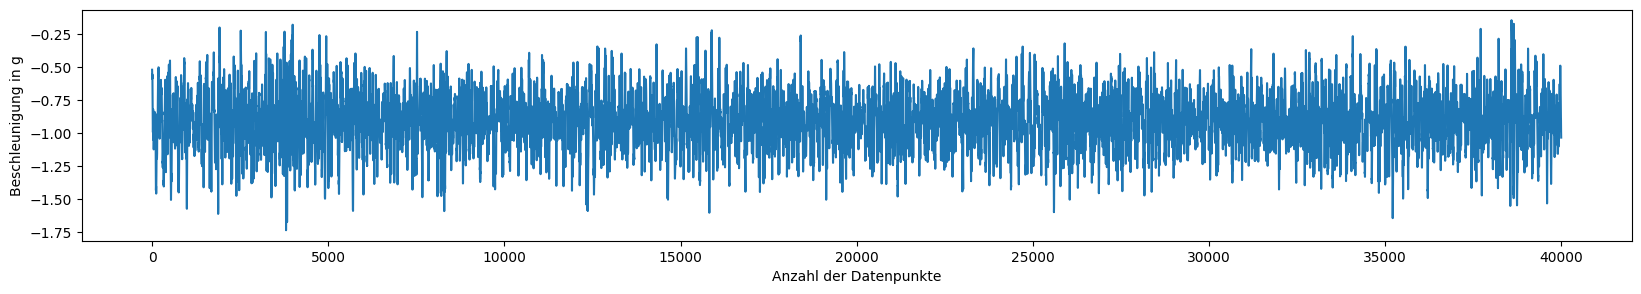

['Sackkarre'] Anzahl Aufnahmen:  248


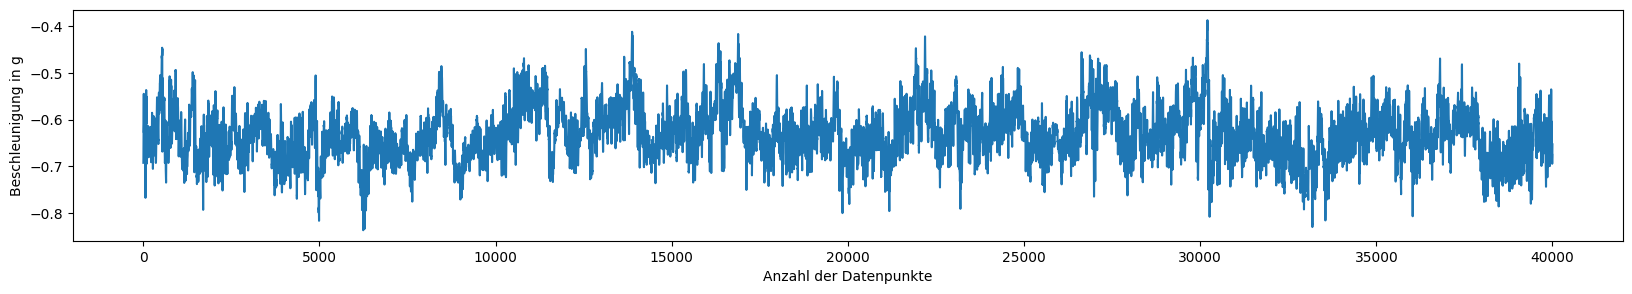

['vert. drehen'] Anzahl Aufnahmen:  241


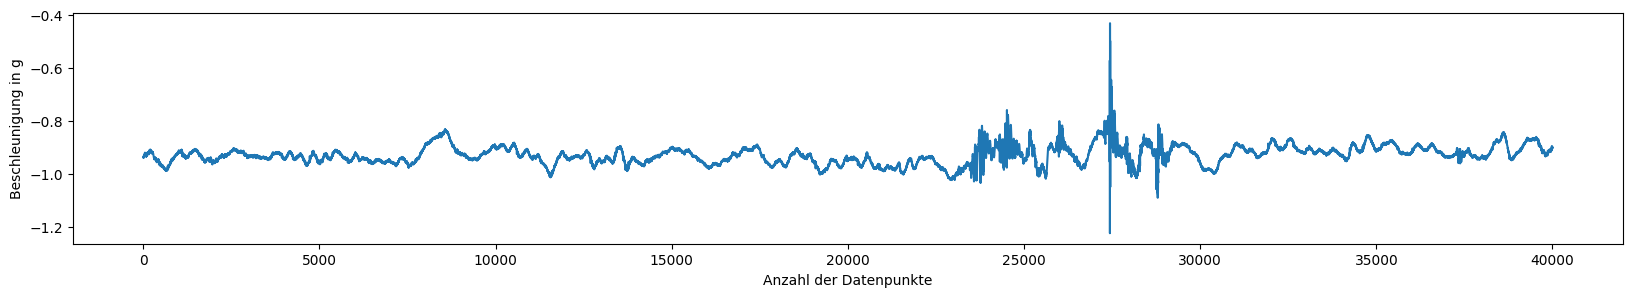

In [67]:
plotRandomDatapointsOfEachLabel(X1_filtered, y1)

In [68]:
import pandas as pd

In [69]:
# X1_filtered, y1

In [70]:
y1.shape

(1983, 1)

In [71]:
X1_filtered.shape

(1983, 40000, 3)

In [72]:
np.max([1,2,3])

3

In [73]:
from scipy.stats import skew, kurtosis

In [74]:
# Assume that X is the 3D numpy array containing the raw acceleration data,
# with shape (1000, 40000, 3), where the first dimension is the number of recordings,
# the second dimension is the number of time points in each recording, and the
# third dimension is the number of acceleration axes.
from scipy import signal
# Define a function to extract the features from a single recording
def extract_features(x):
    max_vals = np.max(x, axis=0)
    min_vals = np.min(x, axis=0)
    mean_vals = np.mean(x, axis=0)
    std_devs = np.std(x, axis=0)
    skews = skew(x, axis=0)
    kurtoses = kurtosis(x, axis=0)
    peak_to_peaks = np.ptp(x, axis=0)
    rms_vals = np.sqrt(np.mean(x**2, axis=0))
    b, a = signal.butter(4, 1100/2000, 'lowpass') # 1100 Hz low-pass filter
    lowfreq = signal.filtfilt(b, a, x, axis=0)
    lowfreq_means = np.mean(lowfreq, axis=0)
    return np.concatenate([max_vals, min_vals, mean_vals, std_devs, skews, kurtoses, peak_to_peaks, rms_vals, lowfreq_means])

# Create an empty numpy array to store the extracted features for all recordings
features = np.zeros((len(X1_filtered), 27))

# Loop through each recording and extract the features
for i in range(len(X1_filtered)):
    x = X1_filtered[i,:,:]
    features[i,:] = extract_features(x)

# Print the shape of the feature matrix
print(features.shape)

(1983, 27)


In [75]:
len(X_filtered_evaluation)

405

In [76]:
features_evaluation = np.zeros((len(X_filtered_evaluation), 27))

for i in range(len(X_filtered_evaluation)):
    x = X_filtered_evaluation[i,:,:]
    features_evaluation[i,:] = extract_features(x)

print(features_evaluation.shape)

(405, 27)


In [77]:
len(y_evaluation)

405

In [78]:
features_evaluation

array([[ 6.92419339e-01,  5.42140549e-02,  2.92161680e-01, ...,
        -9.89686702e-02, -2.20290921e-02, -6.60350091e-01],
       [ 8.59354223e-01,  6.02814367e-02,  2.06017580e-01, ...,
         8.91483721e-03, -2.97387483e-02, -7.03763481e-01],
       [ 7.35226634e-01,  5.10253460e-01,  3.39311744e-01, ...,
        -6.05715185e-05, -2.39413061e-02, -9.10438339e-01],
       ...,
       [ 2.09026257e-01,  3.34493521e-01, -8.01129390e-01, ...,
        -1.24906650e-01,  9.59357421e-03, -9.25642818e-01],
       [ 1.45371253e-01,  2.76970669e-01, -5.96699678e-01, ...,
        -6.99367585e-02,  5.47558261e-02, -9.06648547e-01],
       [ 2.38316974e-01,  1.53123105e-01, -7.18559886e-01, ...,
         8.46332136e-02, -7.82604170e-03, -9.08632863e-01]])

RANDOMFOREST

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(features, y1, stratify=y1, random_state=42)

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
y_train.ravel()

array(['GLT_Rollwagen', 'Hubwagen', 'GLT_Rollwagen', ..., 'vert. drehen',
       'Gehen', 'vert. drehen'], dtype=object)

In [83]:
clf = RandomForestClassifier(n_estimators=20, max_depth=20, n_jobs=-1)
clf.fit(X_train, y_train.ravel())

RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1)

In [84]:
clf.score(X_test, y_test.ravel())

0.9858870967741935

In [85]:
print(features.shape, y1.shape)

(1983, 27) (1983, 1)


In [86]:
clfx = RandomForestClassifier(n_estimators=20, max_depth=20, n_jobs=-1)
clfx.fit(features, y1.ravel())

RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1)

In [87]:
clfx.score(features_evaluation, y_evaluation.ravel())

0.9358024691358025

# Datenvorverarbeitung

# Feature Engineering

# Training

In [88]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [89]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# TENSORFLOW

In [90]:
train_features = X_train
train_labels = y_train.ravel()
test_features = X_test
test_labels = y_test.ravel()

In [91]:
evaluation_features = features_evaluation
evaluation_labels = y_evaluation.ravel()

In [92]:
# Reshape the input features
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

In [93]:
evaluation_features = evaluation_features.reshape(evaluation_features.shape[0], evaluation_features.shape[1], 1)

In [94]:
num_classes = len(np.unique(train_labels))

In [95]:
len(np.unique(train_labels))

9

In [96]:
len(np.unique(test_labels))

9

In [97]:
num_classes

9

In [98]:
for idx, key in enumerate(colorLookup):
    print(f"{idx} : {key}")
    colorLookup[key] = idx

0 : GLT_Rollwagen
1 : Gehen
2 : HebenSenken
3 : Hubwagen
4 : Kiste liegt
5 : Rollenbahn
6 : Rolltisch
7 : Sackkarre
8 : vert. drehen


In [99]:
for idx, label in enumerate(train_labels):
    train_labels[idx] = colorLookup[label]

In [100]:
for idx, label in enumerate(test_labels):
    test_labels[idx] = colorLookup[label]

In [101]:
for idx, label in enumerate(evaluation_labels):
    evaluation_labels[idx] = colorLookup[label]

In [102]:
evaluation_labels

array([2, 2, 3, 7, 8, 6, 4, 6, 8, 5, 3, 7, 4, 2, 3, 0, 0, 0, 3, 1, 7, 3,
       5, 4, 3, 7, 7, 4, 5, 6, 5, 4, 7, 0, 8, 3, 2, 3, 8, 0, 6, 2, 6, 4,
       6, 4, 5, 4, 3, 8, 6, 0, 5, 2, 1, 0, 4, 8, 2, 3, 0, 1, 0, 6, 7, 8,
       0, 1, 8, 1, 5, 8, 5, 8, 5, 7, 2, 0, 7, 6, 3, 6, 5, 2, 8, 2, 5, 0,
       2, 1, 1, 2, 7, 5, 4, 1, 1, 6, 8, 3, 6, 1, 2, 5, 7, 2, 6, 3, 2, 3,
       6, 8, 4, 1, 4, 7, 7, 8, 0, 1, 8, 0, 7, 3, 7, 2, 1, 8, 5, 3, 7, 6,
       1, 4, 0, 2, 7, 7, 7, 0, 7, 3, 7, 3, 7, 2, 7, 7, 4, 5, 7, 6, 4, 6,
       3, 4, 0, 2, 4, 4, 7, 1, 0, 1, 2, 3, 0, 8, 4, 1, 7, 4, 4, 3, 5, 0,
       7, 5, 0, 1, 0, 5, 0, 4, 4, 8, 6, 5, 7, 3, 6, 2, 1, 3, 2, 2, 3, 2,
       4, 5, 3, 8, 5, 5, 6, 3, 5, 0, 4, 5, 0, 4, 0, 6, 2, 6, 0, 3, 2, 2,
       1, 4, 8, 4, 1, 1, 8, 0, 3, 2, 0, 4, 5, 1, 3, 2, 1, 0, 6, 2, 1, 8,
       6, 1, 4, 8, 4, 5, 1, 8, 3, 1, 0, 5, 4, 1, 2, 2, 7, 0, 3, 8, 3, 6,
       0, 5, 3, 8, 5, 0, 4, 2, 7, 3, 1, 7, 2, 6, 4, 7, 4, 0, 6, 1, 1, 7,
       5, 1, 7, 6, 8, 0, 2, 5, 2, 0, 1, 4, 2, 2, 1,

In [103]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [104]:
evaluation_labels = to_categorical(evaluation_labels, num_classes=num_classes)

In [105]:
evaluation_labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [106]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(9, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    return model

In [107]:
# Create the model
model = create_model(input_shape=train_features.shape[1:])

In [108]:
train_features.shape

(1487, 27, 1)

In [109]:
train_labels.shape

(1487, 9)

In [110]:
# Compile the model
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(train_features, train_labels, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_features, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/100
38/38 [==============================] - 3s 8ms/step - loss: 2.1862 - accuracy: 0.2405 - val_loss: 1.7962 - val_accuracy: 0.4732
Epoch 2/100
38/38 [==============================] - 0s 3ms/step - loss: 1.6457 - accuracy: 0.4567 - val_loss: 1.2095 - val_accuracy: 0.6443
Epoch 3/100
38/38 [==============================] - 0s 3ms/step - loss: 1.2215 - accuracy: 0.6131 - val_loss: 0.8067 - val_accuracy: 0.7416
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 0.9369 - accuracy: 0.6627 - val_loss: 0.6036 - val_accuracy: 0.8289
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 0.7656 - accuracy: 0.7485 - val_loss: 0.4694 - val_accuracy: 0.8993
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 0.6464 - accuracy: 0.7872 - val_loss: 0.3792 - val_accuracy: 0.9027
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 0.5904 - accuracy: 0.8049 - val_loss: 0.2998 - val_accuracy: 0.9329
Epoch 8/100
3

In [111]:
train_features.shape

(1487, 27, 1)

In [112]:
np.concatenate((train_features, test_features), axis=0)

array([[[ 0.45197111],
        [ 0.4518082 ],
        [ 0.19561749],
        ...,
        [-0.0146553 ],
        [-0.01057537],
        [-0.90973816]],

       [[ 0.36708806],
        [ 0.43339875],
        [ 0.20511476],
        ...,
        [ 0.00437258],
        [-0.02252534],
        [-0.91053297]],

       [[ 2.22306826],
        [ 1.84305334],
        [ 2.35444825],
        ...,
        [-0.04113621],
        [-0.01783932],
        [-0.90860687]],

       ...,

       [[ 0.90624131],
        [ 0.20592583],
        [-0.32086941],
        ...,
        [ 0.56422064],
        [-0.00634557],
        [-0.73244917]],

       [[-0.20492147],
        [ 0.33928281],
        [-0.11029321],
        ...,
        [-0.66665296],
        [ 0.02423274],
        [-0.65334621]],

       [[ 0.94226672],
        [ 0.1955011 ],
        [-0.36855788],
        ...,
        [ 0.67506697],
        [-0.07757284],
        [-0.63687615]]])

In [113]:
modelx = create_model(input_shape=train_features.shape[1:])
# Compile the model
optimizerx = Adam(lr=0.0001)
modelx.compile(optimizer=optimizerx, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stoppingx = EarlyStopping(patience=10, restore_best_weights=True)
modelx.fit(np.concatenate((train_features, test_features), axis=0), np.concatenate((train_labels, test_labels), axis=0), epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stoppingx])


Epoch 1/200
50/50 [==============================] - 1s 7ms/step - loss: 2.0267 - accuracy: 0.2831 - val_loss: 1.6508 - val_accuracy: 0.5390
Epoch 2/200
50/50 [==============================] - 0s 3ms/step - loss: 1.5413 - accuracy: 0.4760 - val_loss: 1.2319 - val_accuracy: 0.6851
Epoch 3/200
50/50 [==============================] - 0s 3ms/step - loss: 1.3822 - accuracy: 0.5454 - val_loss: 1.0231 - val_accuracy: 0.7406
Epoch 4/200
50/50 [==============================] - 0s 3ms/step - loss: 1.0303 - accuracy: 0.6608 - val_loss: 0.8010 - val_accuracy: 0.7909
Epoch 5/200
50/50 [==============================] - 0s 3ms/step - loss: 0.8436 - accuracy: 0.7106 - val_loss: 0.8171 - val_accuracy: 0.7909
Epoch 6/200
50/50 [==============================] - 0s 3ms/step - loss: 0.7714 - accuracy: 0.7491 - val_loss: 0.5896 - val_accuracy: 0.8589
Epoch 7/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.8064 - val_loss: 0.5350 - val_accuracy: 0.8388
Epoch 8/200
5

In [114]:
evaluation_loss, evaluation_acc = modelx.evaluate(evaluation_features, evaluation_labels, verbose=2)
print('\nTest accuracy:', evaluation_acc)

13/13 - 0s - loss: 1.3181 - accuracy: 0.8198 - 41ms/epoch - 3ms/step

Test accuracy: 0.819753110408783


In [115]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 27, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 25, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 128)            24704 

In [116]:
from tensorflow import keras

In [117]:
train_features.shape

(1487, 27, 1)

In [118]:
train_labels.shape

(1487, 9)

In [119]:
test_features.shape

(496, 27, 1)

In [120]:
test_labels.shape

(496, 9)

In [121]:
num_classes = 9

# Define the model architecture
models = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=train_features.shape[1:]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
models.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping
early_stoppings = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
models.fit(train_features, train_labels, epochs=50, validation_data=(test_features, test_labels), callbacks=[early_stoppings])

# Evaluate the model on test data
score = models.evaluate(test_features, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
47/47 [==============================] - 1s 4ms/step - loss: 1.4376 - accuracy: 0.5588 - val_loss: 0.5579 - val_accuracy: 0.8831
Epoch 2/50
47/47 [==============================] - 0s 2ms/step - loss: 0.4926 - accuracy: 0.8863 - val_loss: 0.3672 - val_accuracy: 0.9093
Epoch 3/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2937 - accuracy: 0.9173 - val_loss: 0.4954 - val_accuracy: 0.9435
Epoch 4/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2899 - accuracy: 0.9314 - val_loss: 0.4549 - val_accuracy: 0.9234
Epoch 5/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2188 - accuracy: 0.9388 - val_loss: 0.5542 - val_accuracy: 0.9435
Epoch 6/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.9523 - val_loss: 0.4718 - val_accuracy: 0.9556
Epoch 7/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2174 - accuracy: 0.9415 - val_loss: 0.5654 - val_accuracy: 0.9375
Test loss: 0.5653812

In [122]:
modelsx = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=train_features.shape[1:]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
modelsx.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping
early_stoppings = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
modelsx.fit(np.concatenate((train_features, test_features), axis=0), np.concatenate((train_labels, test_labels), axis=0), epochs=50, validation_data=(test_features, test_labels), callbacks=[early_stoppings])

# Evaluate the model on test data
score = modelsx.evaluate(test_features, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
62/62 [==============================] - 1s 3ms/step - loss: 1.2995 - accuracy: 0.6369 - val_loss: 0.5356 - val_accuracy: 0.8609
Epoch 2/50
62/62 [==============================] - 0s 2ms/step - loss: 0.4652 - accuracy: 0.8870 - val_loss: 0.4088 - val_accuracy: 0.9113
Epoch 3/50
62/62 [==============================] - 0s 2ms/step - loss: 0.3807 - accuracy: 0.9294 - val_loss: 0.4939 - val_accuracy: 0.8972
Epoch 4/50
62/62 [==============================] - 0s 2ms/step - loss: 0.3179 - accuracy: 0.9244 - val_loss: 0.1098 - val_accuracy: 0.9698
Epoch 5/50
62/62 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.9450 - val_loss: 0.2128 - val_accuracy: 0.9657
Epoch 6/50
62/62 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 0.9536 - val_loss: 0.0967 - val_accuracy: 0.9819
Epoch 7/50
62/62 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9586 - val_loss: 0.1149 - val_accuracy: 0.9516
Epoch 8/50
62/62 [==

In [123]:
scores = modelsx.evaluate(evaluation_features, evaluation_labels, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 2.315814256668091
Test accuracy: 0.8074073791503906


In [129]:
y1.ravel()

array(['Sackkarre', 'Hubwagen', 'Gehen', ..., 'GLT_Rollwagen',
       'vert. drehen', 'GLT_Rollwagen'], dtype=object)

In [200]:
import numpy as np

def reduceRecordingDuration(X, y):
    # Define the input parameters
    recording_length = 10  # in seconds
    sampling_rate = 4000  # in Hz
    new_length = 1  # in seconds
    overlap = 0.1  # 10% overlap

    # Load the original recording data and labels (replace with your actual data)
    num_recordings = len(X)
    original_recordings = X#np.random.randn(num_recordings, recording_length * sampling_rate, 3)
    original_labels = y

    # Calculate the number of new samples and new recordings
    num_new_samples = new_length * sampling_rate
    overlap_samples = int(num_new_samples * overlap)
    num_new_recordings = int(np.floor((recording_length * sampling_rate - num_new_samples) / overlap_samples) + 1)

    # Initialize the new recordings and labels arrays
    new_recordings = np.zeros((num_recordings * num_new_recordings, num_new_samples, 3))
    new_labels = np.empty((num_recordings * num_new_recordings,),dtype=object)

    # Split the original recordings and labels into the new recordings and labels
    for i in range(num_recordings):
        for j in range(num_new_recordings):
            start = j * overlap_samples
            end = start + num_new_samples
            new_recordings[i*num_new_recordings+j] = original_recordings[i, start:end]
            new_labels[i*num_new_recordings+j] = original_labels[i]
    return new_recordings, new_labels


In [201]:
X_evaluation3s, y_evaluation3s = reduceRecordingDuration(X_evaluation, y_evaluation)

In [202]:
X_evaluation3s.shape

(36855, 4000, 3)

In [203]:
y_evaluation3s.shape

(36855,)

In [198]:
print(X_evaluation.shape, y_evaluation.shape)

(405, 40000, 3) (405, 1)


TypeError: only integer scalar arrays can be converted to a scalar index

In [136]:
original_recordings.shape

(1983, 40000, 3)

In [137]:
new_recordings.shape

(180453, 4000, 3)

In [145]:
new_labels.shape

(180453,)

In [332]:
colorLookup

{'GLT_Rollwagen': 0,
 'Gehen': 1,
 'HebenSenken': 2,
 'Hubwagen': 3,
 'Kiste liegt': 4,
 'Rollenbahn': 5,
 'Rolltisch': 6,
 'Sackkarre': 7,
 'vert. drehen': 8}

[0] Anzahl Aufnahmen:  4095


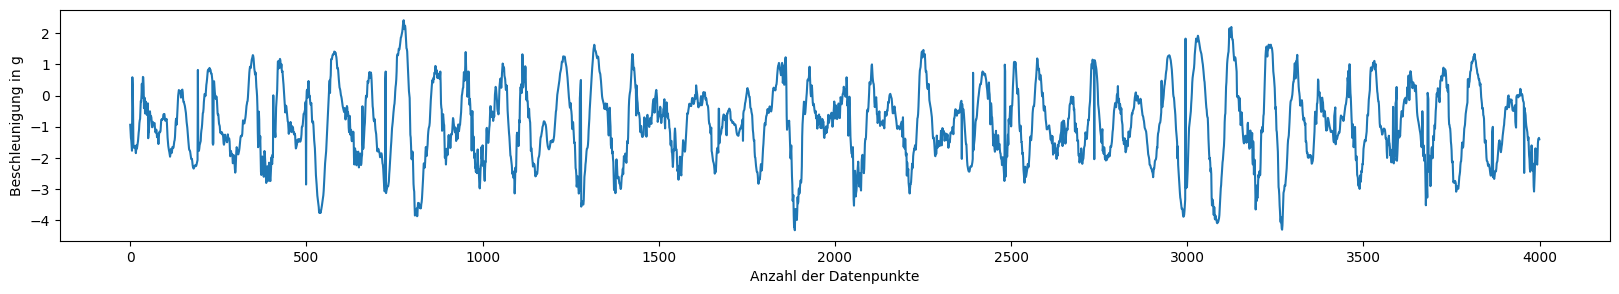

[1] Anzahl Aufnahmen:  4095


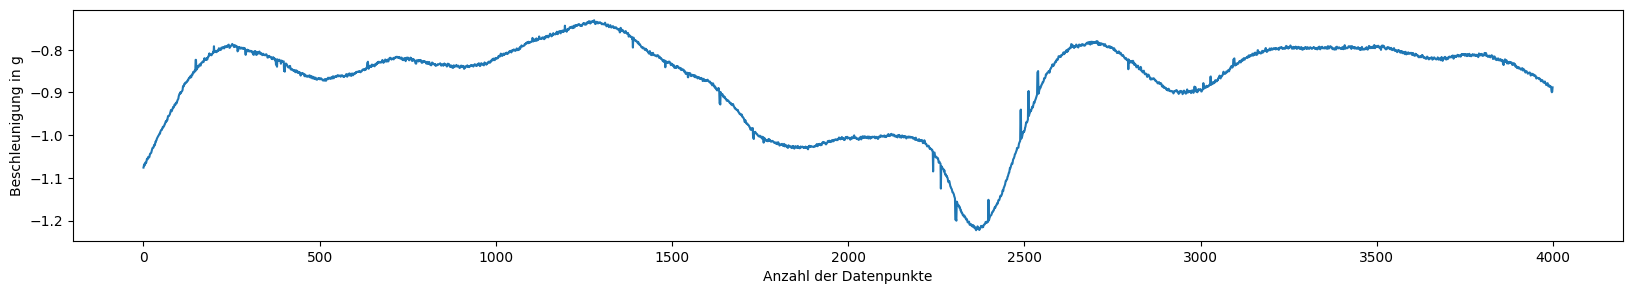

[2] Anzahl Aufnahmen:  4095


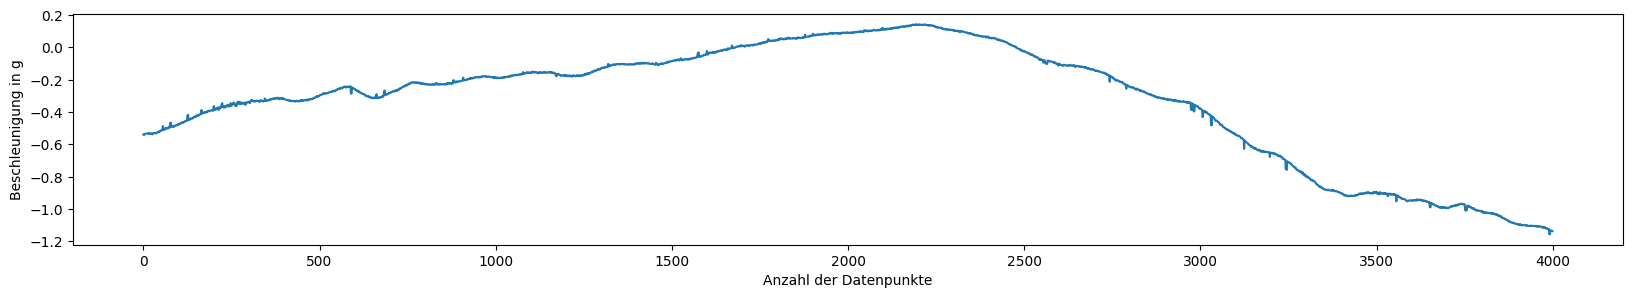

[3] Anzahl Aufnahmen:  4095


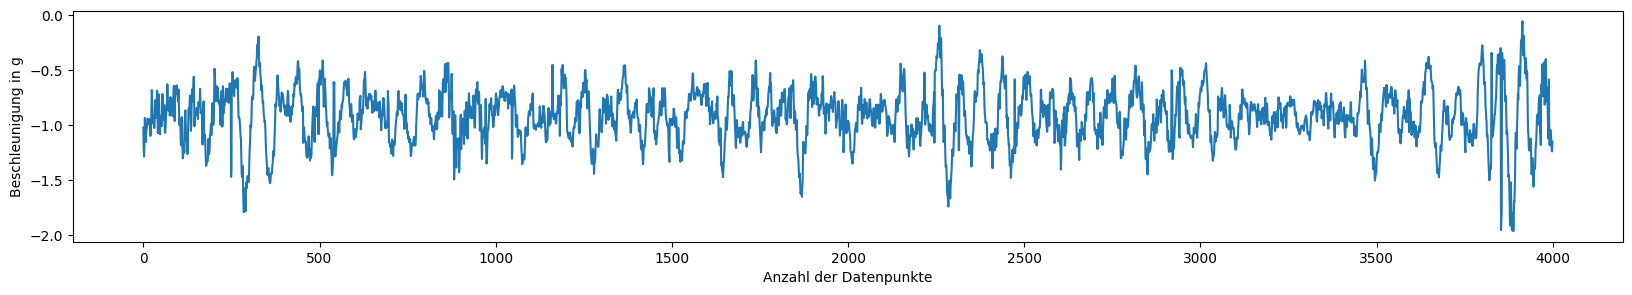

[4] Anzahl Aufnahmen:  4095


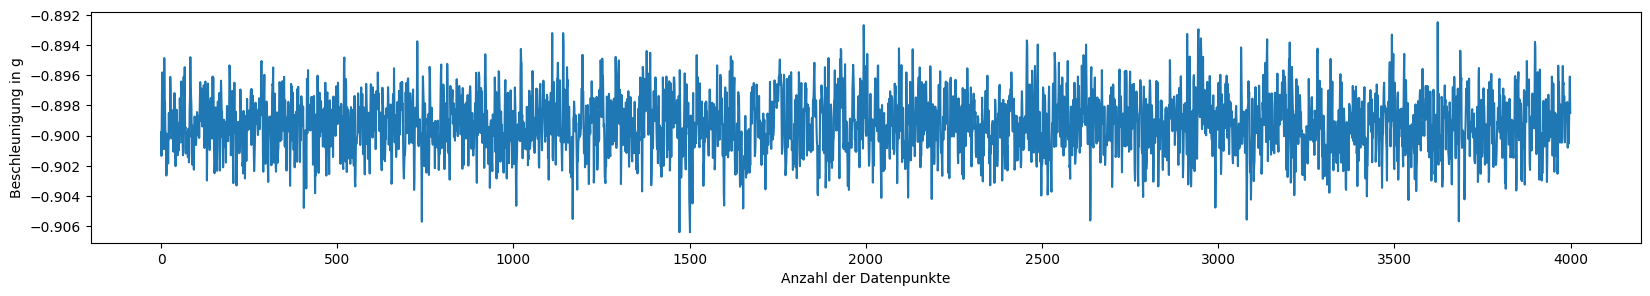

[5] Anzahl Aufnahmen:  4095


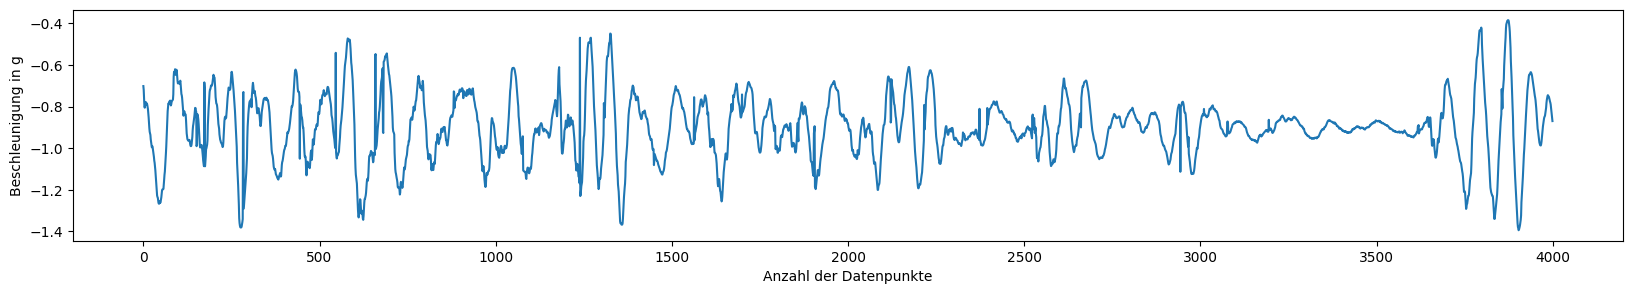

[6] Anzahl Aufnahmen:  4095


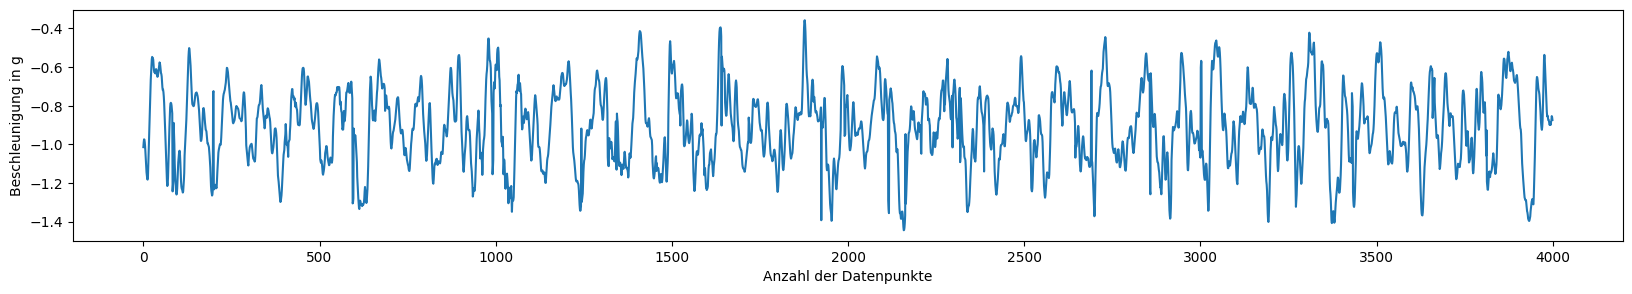

[7] Anzahl Aufnahmen:  4095


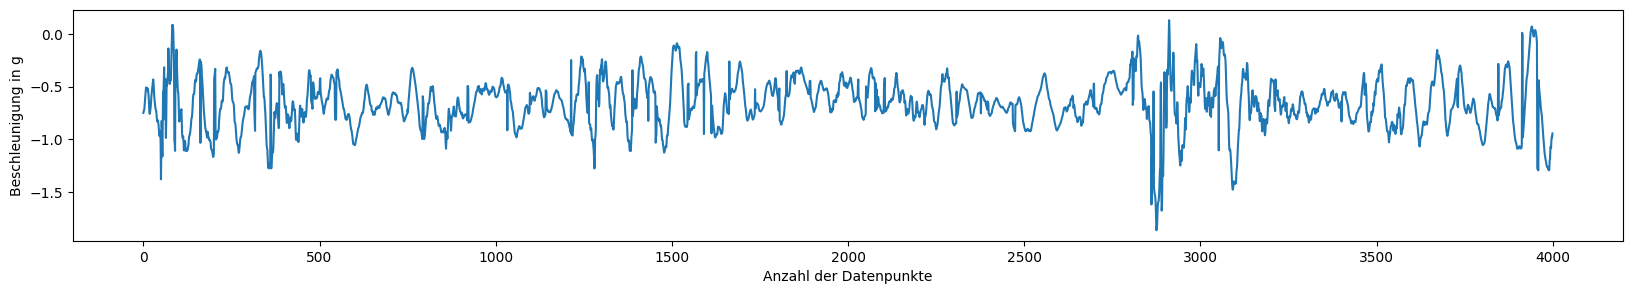

[8] Anzahl Aufnahmen:  4095


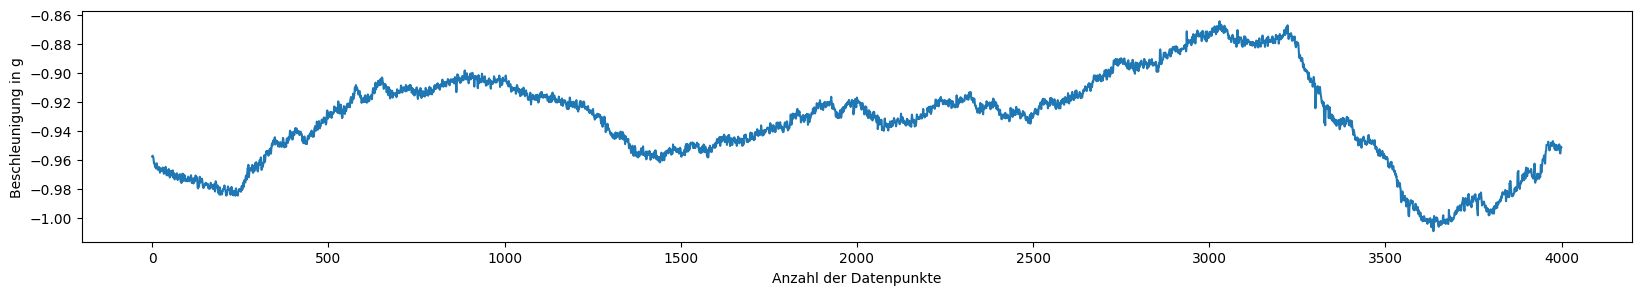

In [204]:
plotRandomDatapointsOfEachLabel(X_evaluation3s, y_evaluation3s)

# 3 SECOND FEATURES

In [206]:
# Create an empty numpy array to store the extracted features for all recordings
def extractFeaturesFromX(X):
    features3s = np.zeros((len(X), 27))

    # Loop through each recording and extract the features
    for i in range(len(X)):
        x = X[i,:,:]
        features3s[i,:] = extract_features(x)

    # Print the shape of the feature matrix
    print(features3s.shape)
    return features3s

In [205]:
X_evaluation3s.shape

(36855, 4000, 3)

In [207]:
features_evaluation3s = extractFeaturesFromX(X_evaluation3s)

(36855, 27)


In [157]:
new_labels = new_labels.ravel()

In [165]:
new_labels.shape

(180453,)

In [175]:
for idx, labelArray in enumerate(new_labels):
    new_labels[idx] = new_labels[idx][0]

In [210]:
for idx, labelArray in enumerate(y_evaluation3s):
    y_evaluation3s[idx] = y_evaluation3s[idx][0]

In [177]:
new_labels.shape

(180453,)

In [178]:
for idx, label in enumerate(new_labels):
    new_labels[idx] = colorLookup[label]

In [189]:
new_labels = new_labels.astype('int')

In [211]:
y_evaluation3s = y_evaluation3s.astype('int')

In [190]:
X_train3s, X_test3s, y_train3s, y_test3s = train_test_split(features3s, new_labels, stratify=new_labels, random_state=42)

In [191]:
np.unique(y_train3s)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [192]:
X_test3s.shape

(45114, 27)

In [193]:
y_train3s.shape

(135339,)

In [194]:
np.unique(y_train3s)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [195]:
clf3s = RandomForestClassifier(n_estimators=20, max_depth=20, n_jobs=-1)
clf3s.fit(X_train3s, y_train3s)

RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1)

In [197]:
clf3s.score(X_test3s, y_test3s)

0.9943254865451966

In [209]:
np.unique(y_evaluation3s)

array([array([0], dtype=object), array([1], dtype=object),
       array([2], dtype=object), array([3], dtype=object),
       array([4], dtype=object), array([5], dtype=object),
       array([6], dtype=object), array([7], dtype=object),
       array([8], dtype=object)], dtype=object)

In [212]:
clf3s.score(features_evaluation3s, y_evaluation3s)

0.9095645095645095

## TENSORFLOW 2

In [219]:
train_features = X_train3s
train_labels = y_train3s
test_features = X_test3s
test_labels = y_test3s

In [ ]:
#features_evaluation3s, y_evaluation3s

In [225]:
val_features = features_evaluation3s
val_labels = y_evaluation3s

In [226]:
val_features = val_features.reshape(val_features.shape[0], val_features.shape[1], 1)

In [227]:
val_labels = to_categorical(val_labels, num_classes=num_classes)

In [220]:
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

In [221]:
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [222]:
model = create_model(input_shape=train_features.shape[1:])

In [224]:
# Compile the model
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(train_features, train_labels, epochs=100, batch_size=256, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_features, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/100
423/423 [==============================] - 3s 6ms/step - loss: 0.0640 - accuracy: 0.9799 - val_loss: 0.0555 - val_accuracy: 0.9825
Epoch 2/100
423/423 [==============================] - 2s 5ms/step - loss: 0.0585 - accuracy: 0.9814 - val_loss: 0.0508 - val_accuracy: 0.9827
Epoch 3/100
423/423 [==============================] - 2s 5ms/step - loss: 0.0555 - accuracy: 0.9822 - val_loss: 0.0497 - val_accuracy: 0.9843
Epoch 4/100
423/423 [==============================] - 2s 5ms/step - loss: 0.0547 - accuracy: 0.9827 - val_loss: 0.0523 - val_accuracy: 0.9828
Epoch 5/100
423/423 [==============================] - 3s 6ms/step - loss: 0.0535 - accuracy: 0.9828 - val_loss: 0.0463 - val_accuracy: 0.9850
Epoch 6/100
423/423 [==============================] - 2s 6ms/step - loss: 0.0503 - accuracy: 0.9840 - val_loss: 0.0428 - val_accuracy: 0.9850
Epoch 7/100
423/423 [==============================] - 2s 5ms/step - loss: 0.0460 - accuracy: 0.9845 - val_loss: 0.0462 - val_accuracy: 0.9854

In [229]:
val_loss, val_acc = model.evaluate(val_features, val_labels, verbose=2)
print('\nval accuracy:', val_acc)

1152/1152 - 1s - loss: 4.9346 - accuracy: 0.7935 - 1s/epoch - 1ms/step

val accuracy: 0.7934608459472656


In [ ]:
clf3s.score(features_evaluation3s, y_evaluation3s)

In [235]:
train_features.shape[1:]

(27, 1)

In [236]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

array([[[ 1.66585642],
        [ 1.26694773],
        [ 2.27657584],
        ...,
        [ 0.03069868],
        [-0.00440518],
        [-0.90594548]],

       [[ 0.02300611],
        [-0.00272253],
        [-0.90585577],
        ...,
        [ 0.01386254],
        [-0.01008784],
        [-0.91098139]],

       [[ 0.76387984],
        [ 0.32601564],
        [-0.27072091],
        ...,
        [-0.00987994],
        [-0.01648502],
        [-0.90490323]],

       ...,

       [[-0.30452718],
        [ 0.18973538],
        [-0.24298665],
        ...,
        [-0.69564217],
        [ 0.01250772],
        [-0.61907611]],

       [[ 0.09084849],
        [ 0.05974451],
        [-0.3251928 ],
        ...,
        [-0.12199756],
        [-0.06865428],
        [-0.93191844]],

       [[ 1.30516852],
        [ 0.53561719],
        [-0.06379263],
        ...,
        [ 0.29661401],
        [-0.02283763],
        [-0.90213635]]])

In [349]:
# Define the model architecture
modelt = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=train_features.shape[1:]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
modelt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [350]:
modelt.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 27, 512)           1024      
                                                                 
 dropout_25 (Dropout)        (None, 27, 512)           0         
                                                                 
 dense_41 (Dense)            (None, 27, 256)           131328    
                                                                 
 dropout_26 (Dropout)        (None, 27, 256)           0         
                                                                 
 dense_42 (Dense)            (None, 27, 128)           32896     
                                                                 
 dropout_27 (Dropout)        (None, 27, 128)           0         
                                                                 
 dense_43 (Dense)            (None, 27, 64)           

In [351]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [352]:
modelt.fit(train_features, train_labels, epochs=50, validation_data=(test_features, test_labels), callbacks=[early_stopping], batch_size=512)

# Evaluate the model on test data
score = modelt.evaluate(test_features, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
265/265 [==============================] - 3s 6ms/step - loss: 0.5728 - accuracy: 0.7990 - val_loss: 0.2369 - val_accuracy: 0.9172
Epoch 2/50
265/265 [==============================] - 1s 5ms/step - loss: 0.2715 - accuracy: 0.9125 - val_loss: 0.1807 - val_accuracy: 0.9434
Epoch 3/50
265/265 [==============================] - 1s 5ms/step - loss: 0.2206 - accuracy: 0.9296 - val_loss: 0.1696 - val_accuracy: 0.9478
Epoch 4/50
265/265 [==============================] - 1s 5ms/step - loss: 0.2006 - accuracy: 0.9354 - val_loss: 0.1464 - val_accuracy: 0.9559
Epoch 5/50
265/265 [==============================] - 1s 5ms/step - loss: 0.1831 - accuracy: 0.9419 - val_loss: 0.1393 - val_accuracy: 0.9577
Epoch 6/50
265/265 [==============================] - 1s 5ms/step - loss: 0.1756 - accuracy: 0.9432 - val_loss: 0.1421 - val_accuracy: 0.9547
Epoch 7/50
265/265 [==============================] - 1s 5ms/step - loss: 0.1659 - accuracy: 0.9469 - val_loss: 0.1256 - val_accuracy: 0.9620
Epoch 

In [353]:
score = modelt.evaluate(val_features, val_labels, verbose=0)
print('val loss:', score[0])
print('val accuracy:', score[1])

val loss: 0.5414882898330688
val accuracy: 0.8516076803207397


In [354]:
score = modelt.evaluate(val_features, val_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5414882898330688
Test accuracy: 0.8516076803207397


In [355]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [356]:
y_pred = modelt.predict(val_features)

1152/1152 [==============================] - 2s 2ms/step


In [357]:
val_labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [358]:
def percent_to_multiclass(predictions):
    """
    Converts percentual multi-class predictions to integers by choosing the class with the highest probability.
    
    Args:
    - predictions: list of percentual predictions
    
    Returns:
    - list of integer predictions
    """
    return [max(enumerate(p), key=lambda x: x[1])[0] for p in predictions]


In [359]:
def round_to_0_8(predictions):
    """
    Rounds the percentual multi-class predictions to whole numbers between 0 and 8, while keeping the same dimensionality.
    
    Args:
    - predictions: list of percentual predictions
    
    Returns:
    - list of integer predictions, rounded to the nearest whole number between 0 and 8
    """
    return [[min(8, max(0, round(p * 8))) for p in sub_list] for sub_list in predictions]


In [360]:
def predictions_to_classes(predictions):
    """
    Converts multi-class predictions to integer class labels by choosing the class with the highest probability
    and rounding to the nearest integer between 0 and 8.
    
    Args:
    - predictions: list of multi-class predictions
    
    Returns:
    - list of integer class labels with the same dimensionality as the input
    """
    max_indices = [max(enumerate(p), key=lambda x: x[1])[0] for p in predictions]
    rounded_labels = [int(round(p * 8)) for p in max_indices]
    return rounded_labels


In [361]:
y_pred[0]

array([1.4231214e-08, 2.0767811e-05, 9.9997437e-01, 4.5812806e-13,
       5.2123142e-17, 6.7670049e-12, 1.7577881e-10, 4.7283552e-06,
       1.6793732e-07], dtype=float32)

In [362]:
y_pred_rounded = predictions_to_classes(y_pred)

In [363]:
y_pred.shape

(36855, 9)

In [364]:
y_pred_rounded = np.zeros(y_pred.shape)

In [365]:
import numpy as np

def percent_to_int(predictions):
    """
    Converts percentual multi-class predictions to integers between 0 and 8 by rounding to the nearest whole number.
    
    Args:
    - predictions: numpy array of percentual predictions
    
    Returns:
    - numpy array of integer predictions between 0 and 8
    """
    return np.round(predictions * 8).astype(int)


In [366]:
def predictions_to_one_hot(predictions):
    """
    Converts multi-class predictions to one-hot encoded vectors by setting the element corresponding to the
    highest probability to 1 and all other elements to 0. The highest probability is converted to an integer
    between 0 and 8 using rounding.
    
    Args:
    - predictions: list of multi-class predictions
    
    Returns:
    - list of one-hot encoded vectors with the same dimensionality as the input
    """
    one_hots = []
    for p in predictions:
        max_index = max(range(len(p)), key=lambda i: p[i])
        one_hot = [0] * 9
        one_hot[int(round(max_index * 8 / (len(p)-1)))] = 1
        one_hots.append(one_hot)
    return one_hots


In [367]:
y_pred_rounded = predictions_to_one_hot(y_pred)

In [368]:
np.unique(y_pred_rounded)

array([0, 1])

In [369]:
y_pred_rounded

[[0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1,

In [370]:
y_pred.shape

(36855, 9)

In [371]:
val_labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [372]:
y_pred_rounded = np.zeros(y_pred.shape)

In [373]:
y_pred

array([[1.4231214e-08, 2.0767811e-05, 9.9997437e-01, ..., 1.7577881e-10,
        4.7283552e-06, 1.6793732e-07],
       [1.5734603e-12, 1.7320212e-05, 9.9997902e-01, ..., 2.3640313e-12,
        5.7429784e-08, 3.6445042e-06],
       [7.5739441e-12, 1.9258705e-06, 9.9999511e-01, ..., 2.2235037e-12,
        2.2656262e-07, 2.7548042e-06],
       ...,
       [5.0955451e-10, 6.8672287e-01, 3.1283838e-01, ..., 3.0907623e-07,
        1.1493249e-06, 1.9550865e-04],
       [1.9484006e-10, 7.2319877e-01, 2.7664015e-01, ..., 1.7557210e-07,
        5.7457108e-08, 1.0358858e-04],
       [4.9267612e-10, 5.2199739e-01, 4.7711891e-01, ..., 1.3697083e-07,
        2.9024571e-08, 4.0299361e-04]], dtype=float32)

In [374]:
y_pred[0].shape

(9,)

In [375]:
def convertPredOutputToWholeIntegers(preds):
    predsA = np.copy(preds)
    predsA = predsA.astype(float)
    for idx, predictionArray in enumerate(preds):
        max_index = max(range(len(predictionArray)), key=lambda i: predictionArray[i])
        max_index_value = int(round(predictionArray[max_index]))

        tmpArray = np.zeros((9,),dtype=float)
        tmpArray[max_index] = max_index_value
        predsA[idx] = tmpArray
        #print("max index: ", max_index, "value: ", predictionArray[max_index])

    return predsA

In [376]:
y_pred_rounded = convertPredOutputToWholeIntegers(y_pred)

In [377]:
val_labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [378]:
y_pred_rounded

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [379]:
multilabel_confusion_matrix(val_labels, y_pred_rounded)

array([[[32626,   134],
        [    2,  4093]],

       [[32256,   504],
        [  219,  3876]],

       [[32309,   451],
        [  510,  3585]],

       [[31424,  1336],
        [ 1377,  2718]],

       [[32760,     0],
        [    0,  4095]],

       [[30981,  1779],
        [   99,  3996]],

       [[31757,  1003],
        [  903,  3192]],

       [[32741,    19],
        [ 2481,  1614]],

       [[32756,     4],
        [   12,  4083]]])

In [380]:
for key in colorLookup:
    print(key, colorLookup[key])

GLT_Rollwagen 0
Gehen 1
HebenSenken 2
Hubwagen 3
Kiste liegt 4
Rollenbahn 5
Rolltisch 6
Sackkarre 7
vert. drehen 8


In [383]:
colorLookup

{'GLT_Rollwagen': 0,
 'Gehen': 1,
 'HebenSenken': 2,
 'Hubwagen': 3,
 'Kiste liegt': 4,
 'Rollenbahn': 5,
 'Rolltisch': 6,
 'Sackkarre': 7,
 'vert. drehen': 8}

In [382]:
print(classification_report(val_labels, y_pred_rounded))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4095
           1       0.88      0.95      0.91      4095
           2       0.89      0.88      0.88      4095
           3       0.67      0.66      0.67      4095
           4       1.00      1.00      1.00      4095
           5       0.69      0.98      0.81      4095
           6       0.76      0.78      0.77      4095
           7       0.99      0.39      0.56      4095
           8       1.00      1.00      1.00      4095

   micro avg       0.86      0.85      0.85     36855
   macro avg       0.87      0.85      0.84     36855
weighted avg       0.87      0.85      0.84     36855
 samples avg       0.85      0.85      0.85     36855



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Evaluierung

# Logging

# Model-Export